In [2]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [209]:
def drawdown(returns): # Calculate Drawdowns
    cumulative = returns
    highwatermark = cumulative.cummax()
    drawdown = (cumulative / highwatermark)-1
    return drawdown

def max_dd(returns): # Calculate Maxium Drawdowns
    return np.min(drawdown(returns))

def cagr(data): # Calculate CAGR
    years = data.index[-1].year - data.index[0].year
    return (data.iloc[-1] ** (1 / years)) -1
    
def sharpe(returns, days): # Calculate Sharpe Ratio
    return cagr((returns+1).cumprod()) / (np.std(returns) * np.sqrt(days))

def cum(returns): # Calculate Cummlative Returns from Returns
    return (returns+1).cumprod()

def weight_fill(raw, momentum): # Function for matching resampled data with another data
    raw.index = pd.to_datetime(raw.index)
    dummy = pd.DataFrame(pd.to_datetime(np.array(raw.index)), columns=['tmp'])
    dummy.index = raw.index
    dummy['tmp'] = pd.to_datetime(dummy.index)

    momentum.index = pd.to_datetime(momentum.index)
    momentum['tmp'] = pd.to_datetime(momentum.index)

    result = pd.merge(dummy, momentum, on='tmp', how='left')
    result.index = pd.to_datetime(result["tmp"])
    result = result.drop("tmp", axis=1)
    result = result.pad()
    return result

In [325]:
# Load US Data 
loc = os.getcwd() + "/" 
stock = pd.read_csv(loc+"Data/CRSP_CLOSE_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
market = pd.read_csv(loc+"Data/SPX.csv")[["Date","Close"]]
screen = pd.read_csv(loc+"Data/CRSP_CONSTITUENTS_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
screen = screen.applymap(lambda x: np.nan if x==0 else (int(x) if not math.isnan(x) else np.nan))
stock = np.abs(stock)

### Preprocess Data
stock.index = pd.to_datetime(stock.index, format="%Y%m%d")
market.columns = ["date","CLOSE"]
market.index = pd.to_datetime(market["date"])
market = market.drop("date", axis=1)
screen.index = pd.to_datetime(screen.index)

for col in stock.columns:
    if col not in screen.columns:
        stock = stock.drop(col, axis=1)

for idx in market.index:
    if idx not in stock.index:
        market = market.drop(idx, axis=0)

# Calculate Stock Return
stock_return = stock.pct_change()
market_return = market.pct_change()

dummy_matrix = stock.copy()
dummy_matrix[dummy_matrix.isna() == False] = 0

stock_return = stock_return + dummy_matrix
stock_return = stock_return.dropna(how="all", axis=0)
market_return = market_return.dropna(how="all", axis=0)

# Preprocess 2
for idx in screen.index:
    if idx not in stock_return.index:
        screen = screen.drop(idx, axis=0)

In [5]:
### Winsorize the Stock Return
winsor_stock_return = PREPROCESSOR.do_winsorize(stock_return, method='quantile', quantile=0.025, hurdle=0.25)
# winsor_stock_return = PREPROCESSOR.replace_extreme(stock_return, 0.5)
# winsor_stock_return = stock_return.copy() ### When Using no preprocessed stock return

Please Wait...


Winsorizing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:03<00:00, 1807.53it/s]


In [ ]:
# Beta Calculation - upBeta
upBeta = BETA_CALCULATOR()
upBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="up", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
upBeta.beta = upBeta.beta * screen
upBeta.beta.to_csv(loc+"Export/us_upBeta.csv") # Save the Result

In [ ]:
# Beta Calculation - downBeta
downBeta = BETA_CALCULATOR()
downBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="down", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
downBeta.beta = downBeta.beta * screen
downBeta.beta.to_csv(loc+"Export/us_downBeta.csv") # Save the Result

In [376]:
### Weight Calculation ###
upbeta_ = pd.read_csv('./Export/us_upBeta.csv', index_col='date', date_format='%Y-%m-%d')
downbeta_ = pd.read_csv('./Export/us_downBeta.csv', index_col='date', date_format='%Y-%m-%d')
myStrategy = STRATEGY()
myStrategy.straddle(
                upbeta=upbeta_,
                downbeta=downbeta_,
                long_stock_down_hurdle=0.85,
                short_stock_up_hurdle=1,#
                up_minus_down_hurdle=0.55,
                down_minus_up_hurdle=0.25
            )

Please Wait...


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13668.62it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


In [377]:
 # Backtesting
pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return,
                            etf_return = market_return,
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
)


In [378]:
print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]


Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 66405.01it/s]


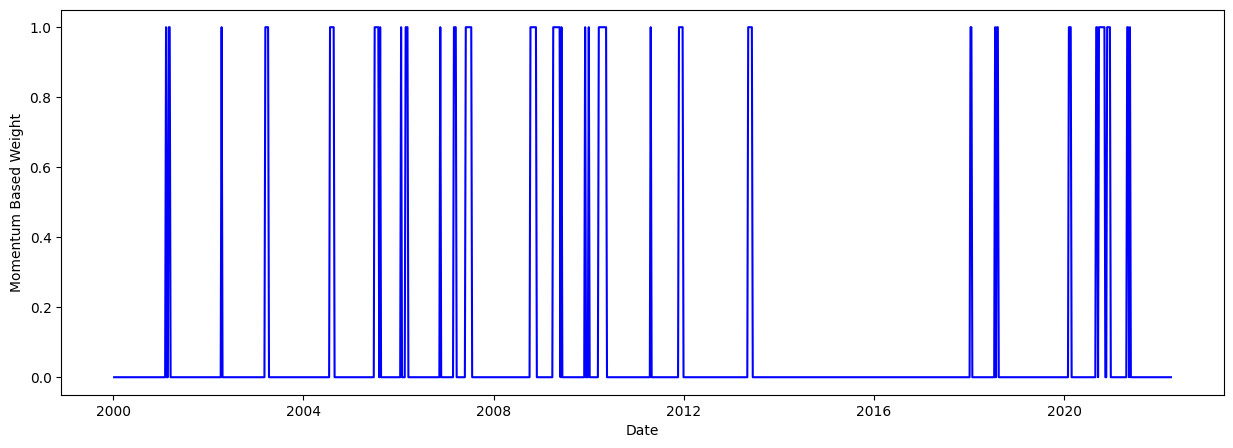

In [370]:
# Calculate Momentum Based Weight from returns of Virtual Portfolio
# Momentums are calucatled automatically without forward looking bias
mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,
                method = 'hurdle_strict', hurdle=0.45)
# Plot Momentum Based Weight for Dynamic Optimization
plt.figure(figsize=(15,5))
plt.xlabel("Date", fontsize=10)
plt.ylabel("Momentum Based Weight", fontsize=10)
plt.plot(mom_weight, color='blue')

In [375]:
# Adjusted resampled weights
filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
momStrategy = STRATEGY()
momStrategy.straddle(
    upbeta=upbeta_,
    downbeta=downbeta_,
    long_stock_down_hurdle=1.2,
    short_stock_up_hurdle=1.2,#
    up_minus_down_hurdle=0.35,
    down_minus_up_hurdle=0.35,
    momentum_weight = filled_weight
)

Please Wait...
(5597,)
(5597, 1)


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15787.75it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


SnP500 market
CAGR: [0.05297627]
Sharpe: [0.59337333]
MDD: -0.5677538894035712
VOL: [0.08927983]

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.10171351]
Sharpe: [0.38291283]
MDD: -0.45171323994420365
VOL: [0.26563097]


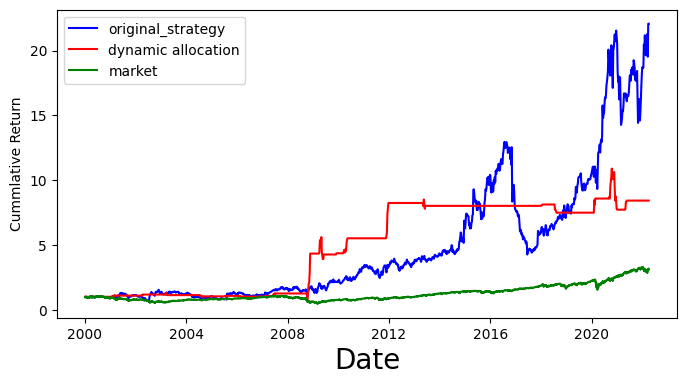

In [372]:
# Backtest the PF
mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )

# Plot Cummlative Returns of PFs
# Blue-Virtual_PF, Red-Momentum_Based_Weight_Adjusted PF, Green-S&P500

plt.figure(figsize=(8,4))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Cummlative Return", fontsize=10)

plt.plot((pf_return+1).cumprod(), color='blue')
plt.plot((mom_pf_return+1).cumprod(), color='red')
plt.plot((market_return+1).cumprod(), color='green')
plt.legend(['original_strategy', 'dynamic allocation', 'market'])

print("SnP500 market")
print("CAGR:", cagr(cum(market_return)).values)
print("Sharpe:", sharpe(market_return, days=52).values)
print("MDD:", max_dd(cum(market_return)))
print("VOL:", cagr(cum(market_return)).values / sharpe(market_return, days=52).values)
print()

print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

print()
print("Beta-Asymmetry with strategy-based momentum")
print("CAGR:", cagr(cum(mom_pf_return)).values)
print("Sharpe:", sharpe(mom_pf_return, days=52).values)
print("MDD:", max_dd(cum(mom_pf_return)))
print("VOL:", cagr(cum(mom_pf_return)).values / sharpe(mom_pf_return, days=52).values)

plt.show()

2000 ~ 2010
SnP500 market
CAGR: [-0.01448607]
Sharpe: [-0.14576318]
MDD: -0.5677538894035712
VOL: [0.09938083]

Beta-Asymmetry Strategy
CAGR: [0.12517022]
Sharpe: [0.30863622]
MDD: -0.4880511995417284
VOL: [0.40555908]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.18618904]
Sharpe: [0.52124914]
MDD: -0.45171323994420365
VOL: [0.35719778]


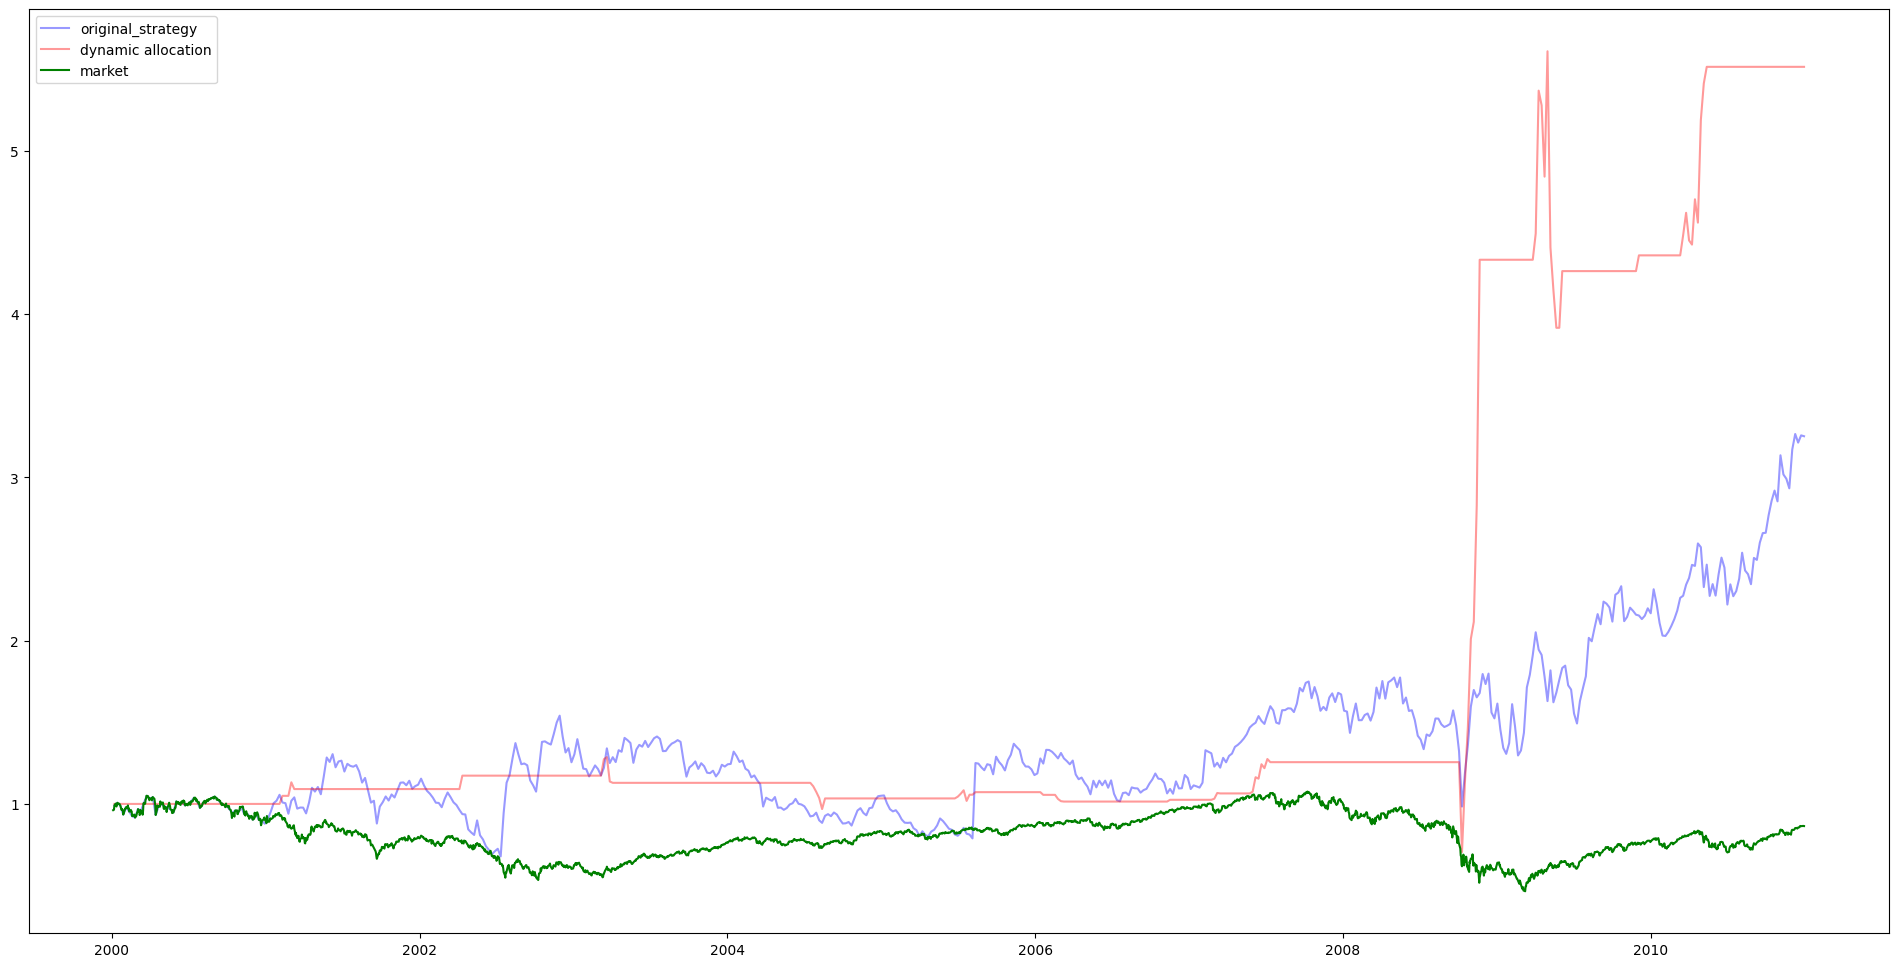

2010 ~ 2020
SnP500 market
CAGR: [0.1291249]
Sharpe: [1.62477187]
MDD: -0.3392495902426059
VOL: [0.07947264]

Beta-Asymmetry Strategy
CAGR: [0.25328342]
Sharpe: [0.7113016]
MDD: -0.6709391348503122
VOL: [0.35608443]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.05962124]
Sharpe: [0.45780675]
MDD: -0.28561369967865746
VOL: [0.13023233]


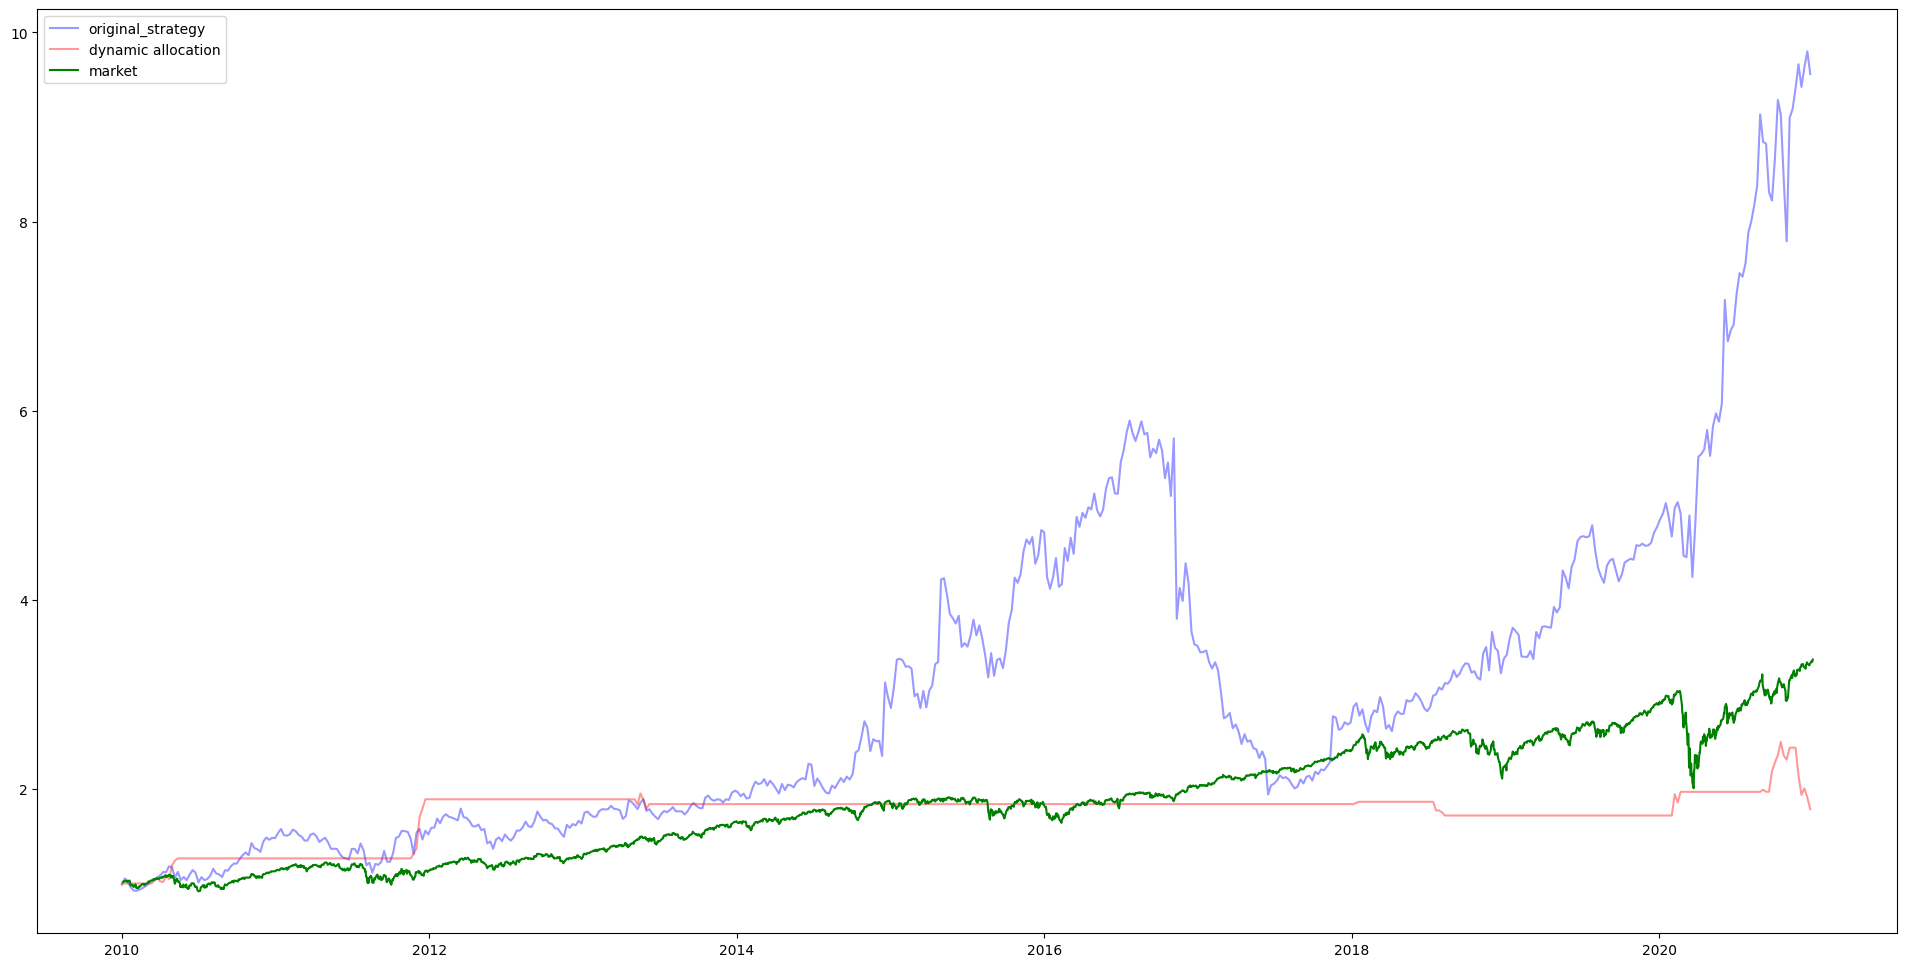

In [373]:
# Visuaized the Periodic Performance of Real PF
for start_year in [2000,2010]:
    end_year = str(start_year+10)
    start_year = str(start_year)
    print(start_year, "~", end_year)
    print("SnP500 market")
    print("CAGR:", cagr(cum(market_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(market_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(market_return[start_year:end_year])))
    print("VOL:", cagr(cum(market_return[start_year:end_year])).values / sharpe(market_return[start_year:end_year], days=52).values)
    print()

    
    print("Beta-Asymmetry Strategy")
    print("CAGR:", cagr(cum(pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(pf_return[start_year:end_year])).values / sharpe(pf_return[start_year:end_year], days=52).values)
    
    print()
    print("Beta-Asymmetry with strategy-based momentum")
    print("CAGR:", cagr(cum(mom_pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(mom_pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(mom_pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(mom_pf_return[start_year:end_year])).values / sharpe(mom_pf_return[start_year:end_year], days=52).values)
    plt.figure(figsize=(24,12))
    plt.plot((pf_return+1)[start_year:end_year].cumprod(), color='blue', alpha=0.4)
    plt.plot((mom_pf_return+1)[start_year:end_year].cumprod(), color='red', alpha=0.4)
    plt.plot((market_return+1)[start_year:end_year].cumprod(), color='green')
    plt.legend(['original_strategy', 'dynamic allocation', 'market'])
    plt.show()

### greedy search (hyperparameter tuning)

In [280]:
from itertools import product
long_stock_down_hurdle = np.arange(0.85, 1.36, 0.1)
short_stock_up_hurdle = np.arange(1.0, 1.31, 0.1)
up_minus_down_hurdle=np.arange(0.45, 0.66, 0.1)
down_minus_up_hurdle=np.arange(0.1, 0.31, 0.1)
items = [long_stock_down_hurdle, short_stock_up_hurdle, up_minus_down_hurdle, down_minus_up_hurdle]
all_comb = list(product(*items))
print(len(all_comb))

216


In [282]:
maxi = -100
mini = -100
comb = all_comb[0]
for x in tqdm(all_comb):
    myStrategy = STRATEGY()
    myStrategy.straddle(
                    upbeta=upbeta_,
                    downbeta=downbeta_,
                    long_stock_down_hurdle=x[0],
                    short_stock_up_hurdle=x[1],
                    up_minus_down_hurdle=x[2],
                    down_minus_up_hurdle=x[3]
                )
    pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return,
                            etf_return = market_return,
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
    )
    sharpe_ = sharpe(pf_return, days=52).values[0]
    mdd_ = max_dd(cum(pf_return))
    if (sharpe_ >= maxi):
        maxi = sharpe_
        mini = mdd_
        comb = x

  0%|                                                                                                                                  | 0/216 [00:00<?, ?it/s]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13377.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12807.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  0%|▌                                                                                                                         | 1/216 [00:06<23:14,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  1%|█▏                                                                                                                        | 2/216 [00:12<22:55,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14422.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14589.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  1%|█▋                                                                                                                        | 3/216 [00:19<23:12,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 11377.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14660.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  2%|██▏                                                                                                                   | 4/216 [17:19<23:57:04, 406.72s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12726.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12941.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  2%|██▋                                                                                                                   | 5/216 [33:44<36:03:52, 615.32s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  3%|███▎                                                                                                                  | 6/216 [33:51<23:48:49, 408.24s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12829.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  3%|███▊                                                                                                                  | 7/216 [33:57<16:04:27, 276.88s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12874.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12892.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  4%|████▎                                                                                                                 | 8/216 [34:04<11:01:19, 190.77s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12982.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  4%|████▉                                                                                                                  | 9/216 [34:10<7:39:12, 133.10s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12923.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  5%|█████▌                                                                                                                 | 10/216 [34:16<5:22:27, 93.92s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12837.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  5%|██████                                                                                                                 | 11/216 [34:22<3:49:24, 67.14s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12931.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  6%|██████▌                                                                                                                | 12/216 [34:29<2:45:32, 48.69s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12930.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  6%|███████▏                                                                                                               | 13/216 [34:35<2:01:17, 35.85s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  6%|███████▋                                                                                                               | 14/216 [34:42<1:30:50, 26.98s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.11it/s]

  7%|████████▎                                                                                                              | 15/216 [34:48<1:09:43, 20.82s/it]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias
Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  7%|████████▉                                                                                                                | 16/216 [34:55<54:49, 16.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  8%|█████████▌                                                                                                               | 17/216 [35:01<44:33, 13.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  8%|██████████                                                                                                               | 18/216 [35:07<37:21, 11.32s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  9%|██████████▋                                                                                                              | 19/216 [35:14<32:28,  9.89s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13059.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  9%|███████████▏                                                                                                             | 20/216 [35:20<28:58,  8.87s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 10%|███████████▊                                                                                                             | 21/216 [35:27<26:20,  8.11s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12986.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 10%|████████████▎                                                                                                            | 22/216 [35:33<24:36,  7.61s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 11%|████████████▉                                                                                                            | 23/216 [35:40<23:16,  7.24s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 11%|█████████████▍                                                                                                           | 24/216 [35:46<22:22,  6.99s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12853.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 12%|██████████████                                                                                                           | 25/216 [35:53<21:54,  6.88s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12994.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 12%|██████████████▌                                                                                                          | 26/216 [35:59<21:23,  6.75s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12974.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 12%|███████████████▏                                                                                                         | 27/216 [36:05<20:55,  6.64s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12934.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 13%|███████████████▋                                                                                                         | 28/216 [36:12<20:27,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 13%|████████████████▏                                                                                                        | 29/216 [36:18<20:14,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12947.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 14%|████████████████▊                                                                                                        | 30/216 [36:25<20:06,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 14%|█████████████████▎                                                                                                       | 31/216 [36:31<19:56,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13040.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 15%|█████████████████▉                                                                                                       | 32/216 [36:38<19:55,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 15%|██████████████████▍                                                                                                      | 33/216 [36:44<20:00,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 16%|███████████████████                                                                                                      | 34/216 [36:51<19:53,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 16%|███████████████████▌                                                                                                     | 35/216 [36:57<19:43,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 17%|████████████████████▏                                                                                                    | 36/216 [37:04<19:36,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 17%|████████████████████▋                                                                                                    | 37/216 [37:10<19:32,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 18%|█████████████████████▎                                                                                                   | 38/216 [37:17<19:28,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 18%|█████████████████████▊                                                                                                   | 39/216 [37:24<19:22,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13022.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10290.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 19%|██████████████████████▍                                                                                                  | 40/216 [37:30<19:16,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13026.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 19%|██████████████████████▉                                                                                                  | 41/216 [37:37<19:09,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 19%|███████████████████████▌                                                                                                 | 42/216 [37:43<19:05,  6.58s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12914.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12924.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 20%|████████████████████████                                                                                                 | 43/216 [37:50<18:42,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12951.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 20%|████████████████████████▋                                                                                                | 44/216 [37:56<18:33,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 21%|█████████████████████████▏                                                                                               | 45/216 [38:03<18:30,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 21%|█████████████████████████▊                                                                                               | 46/216 [38:09<18:20,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13014.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 22%|██████████████████████████▎                                                                                              | 47/216 [38:16<18:19,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 22%|██████████████████████████▉                                                                                              | 48/216 [38:22<18:01,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 23%|███████████████████████████▍                                                                                             | 49/216 [38:28<17:53,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 23%|████████████████████████████                                                                                             | 50/216 [38:35<17:48,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 24%|████████████████████████████▌                                                                                            | 51/216 [38:41<17:40,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 24%|█████████████████████████████▏                                                                                           | 52/216 [38:48<17:36,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 25%|█████████████████████████████▋                                                                                           | 53/216 [38:54<17:37,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13028.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10249.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 25%|██████████████████████████████▎                                                                                          | 54/216 [39:01<17:38,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 25%|██████████████████████████████▊                                                                                          | 55/216 [39:07<17:28,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12968.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 26%|███████████████████████████████▎                                                                                         | 56/216 [39:14<17:24,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12881.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 26%|███████████████████████████████▉                                                                                         | 57/216 [39:20<17:16,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 27%|████████████████████████████████▍                                                                                        | 58/216 [39:27<17:11,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 27%|█████████████████████████████████                                                                                        | 59/216 [39:34<17:08,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12878.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 28%|█████████████████████████████████▌                                                                                       | 60/216 [39:40<16:57,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 28%|██████████████████████████████████▏                                                                                      | 61/216 [39:47<16:59,  6.58s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 29%|██████████████████████████████████▋                                                                                      | 62/216 [39:53<16:51,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 29%|███████████████████████████████████▎                                                                                     | 63/216 [40:00<16:35,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 30%|███████████████████████████████████▊                                                                                     | 64/216 [40:06<16:30,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12916.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 30%|████████████████████████████████████▍                                                                                    | 65/216 [40:13<16:19,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12991.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 31%|████████████████████████████████████▉                                                                                    | 66/216 [40:19<16:14,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12954.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 31%|█████████████████████████████████████▌                                                                                   | 67/216 [40:26<16:13,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10202.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 31%|██████████████████████████████████████                                                                                   | 68/216 [40:32<16:10,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13248.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14527.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 32%|██████████████████████████████████████▋                                                                                  | 69/216 [40:39<15:56,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12759.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 32%|███████████████████████████████████████▏                                                                                 | 70/216 [40:45<15:46,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13574.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15387.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 33%|███████████████████████████████████████▊                                                                                 | 71/216 [40:51<15:31,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14316.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 33%|████████████████████████████████████████▎                                                                                | 72/216 [40:58<15:24,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12838.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12855.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 34%|████████████████████████████████████████▉                                                                                | 73/216 [41:04<15:18,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12859.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12892.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 34%|█████████████████████████████████████████▍                                                                               | 74/216 [41:11<15:18,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12768.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 35%|██████████████████████████████████████████                                                                               | 75/216 [41:17<15:12,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12821.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 35%|██████████████████████████████████████████▌                                                                              | 76/216 [41:24<15:05,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 36%|███████████████████████████████████████████▏                                                                             | 77/216 [41:30<14:57,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 36%|███████████████████████████████████████████▋                                                                             | 78/216 [41:37<14:52,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 37%|████████████████████████████████████████████▎                                                                            | 79/216 [41:43<14:47,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 37%|████████████████████████████████████████████▊                                                                            | 80/216 [41:50<14:39,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12852.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 38%|█████████████████████████████████████████████▍                                                                           | 81/216 [41:56<14:30,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12835.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10142.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 38%|█████████████████████████████████████████████▉                                                                           | 82/216 [42:03<14:29,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12762.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 38%|██████████████████████████████████████████████▍                                                                          | 83/216 [42:09<14:21,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 39%|███████████████████████████████████████████████                                                                          | 84/216 [42:16<14:13,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13664.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13189.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 39%|███████████████████████████████████████████████▌                                                                         | 85/216 [42:22<14:05,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12938.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 40%|████████████████████████████████████████████████▏                                                                        | 86/216 [42:28<13:55,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12739.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 40%|████████████████████████████████████████████████▋                                                                        | 87/216 [42:35<13:48,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12839.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 41%|█████████████████████████████████████████████████▎                                                                       | 88/216 [42:41<13:42,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12906.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 41%|█████████████████████████████████████████████████▊                                                                       | 89/216 [42:48<13:36,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 42%|██████████████████████████████████████████████████▍                                                                      | 90/216 [42:54<13:33,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 42%|██████████████████████████████████████████████████▉                                                                      | 91/216 [43:01<13:26,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12951.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 43%|███████████████████████████████████████████████████▌                                                                     | 92/216 [43:07<13:18,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13378.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 43%|████████████████████████████████████████████████████                                                                     | 93/216 [43:14<13:17,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12949.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 44%|████████████████████████████████████████████████████▋                                                                    | 94/216 [43:20<13:12,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12877.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12999.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 44%|█████████████████████████████████████████████████████▏                                                                   | 95/216 [43:27<13:03,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12777.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 44%|█████████████████████████████████████████████████████▊                                                                   | 96/216 [43:33<13:01,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12947.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 45%|██████████████████████████████████████████████████████▎                                                                  | 97/216 [43:40<12:52,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12910.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12930.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 45%|██████████████████████████████████████████████████████▉                                                                  | 98/216 [43:46<12:44,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12919.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 46%|███████████████████████████████████████████████████████▍                                                                 | 99/216 [43:52<12:36,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12939.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 46%|███████████████████████████████████████████████████████▌                                                                | 100/216 [43:59<12:32,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12923.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 47%|████████████████████████████████████████████████████████                                                                | 101/216 [44:06<12:30,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12815.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 47%|████████████████████████████████████████████████████████▋                                                               | 102/216 [44:12<12:22,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12811.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12801.17it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 48%|█████████████████████████████████████████████████████████▏                                                              | 103/216 [44:19<12:18,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12939.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 48%|█████████████████████████████████████████████████████████▊                                                              | 104/216 [44:25<12:11,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12818.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12938.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 49%|██████████████████████████████████████████████████████████▎                                                             | 105/216 [44:32<12:02,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12969.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12959.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 49%|██████████████████████████████████████████████████████████▉                                                             | 106/216 [44:38<11:53,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12899.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12818.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 50%|███████████████████████████████████████████████████████████▍                                                            | 107/216 [44:45<11:46,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12796.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12743.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 50%|████████████████████████████████████████████████████████████                                                            | 108/216 [44:51<11:39,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12714.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12902.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 50%|████████████████████████████████████████████████████████████▌                                                           | 109/216 [44:57<11:31,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12937.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 51%|█████████████████████████████████████████████████████████████                                                           | 110/216 [45:04<11:27,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12870.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12927.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 51%|█████████████████████████████████████████████████████████████▋                                                          | 111/216 [45:11<11:20,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13527.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 52%|██████████████████████████████████████████████████████████████▏                                                         | 112/216 [45:17<11:12,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12958.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12973.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 52%|██████████████████████████████████████████████████████████████▊                                                         | 113/216 [45:23<11:05,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13611.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12994.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 53%|███████████████████████████████████████████████████████████████▎                                                        | 114/216 [45:30<10:58,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12807.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12954.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 53%|███████████████████████████████████████████████████████████████▉                                                        | 115/216 [45:36<10:55,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12922.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 54%|████████████████████████████████████████████████████████████████▍                                                       | 116/216 [45:43<10:51,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12820.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12914.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 54%|█████████████████████████████████████████████████████████████████                                                       | 117/216 [45:49<10:43,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12946.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 55%|█████████████████████████████████████████████████████████████████▌                                                      | 118/216 [45:56<10:35,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13390.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12777.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 55%|██████████████████████████████████████████████████████████████████                                                      | 119/216 [46:02<10:27,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13734.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 120/216 [46:09<10:19,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 56%|███████████████████████████████████████████████████████████████████▏                                                    | 121/216 [46:15<10:16,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12841.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 56%|███████████████████████████████████████████████████████████████████▊                                                    | 122/216 [46:22<10:08,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 57%|████████████████████████████████████████████████████████████████████▎                                                   | 123/216 [46:28<10:01,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12932.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12865.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 57%|████████████████████████████████████████████████████████████████████▉                                                   | 124/216 [46:35<09:56,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12875.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12906.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 125/216 [46:41<09:48,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 58%|██████████████████████████████████████████████████████████████████████                                                  | 126/216 [46:48<09:45,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12895.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 127/216 [46:54<09:37,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12900.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 59%|███████████████████████████████████████████████████████████████████████                                                 | 128/216 [47:01<09:29,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13350.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13509.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 60%|███████████████████████████████████████████████████████████████████████▋                                                | 129/216 [47:07<09:22,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13632.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 60%|████████████████████████████████████████████████████████████████████████▏                                               | 130/216 [47:14<09:23,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12889.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 61%|████████████████████████████████████████████████████████████████████████▊                                               | 131/216 [47:20<09:16,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12822.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 132/216 [47:27<09:08,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12921.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 133/216 [47:33<09:00,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13766.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 134/216 [47:40<08:51,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12825.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12888.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 62%|███████████████████████████████████████████████████████████████████████████                                             | 135/216 [47:46<08:42,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12603.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 136/216 [47:53<08:35,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13117.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12716.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 63%|████████████████████████████████████████████████████████████████████████████                                            | 137/216 [47:59<08:29,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12653.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12814.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 138/216 [48:06<08:27,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12845.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 139/216 [48:12<08:21,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12549.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13208.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 140/216 [48:19<08:15,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13138.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12660.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 141/216 [48:25<08:09,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12815.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 142/216 [48:32<08:04,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12931.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 143/216 [48:38<07:55,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12910.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 144/216 [48:45<07:48,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12747.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12820.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 145/216 [48:52<07:46,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13262.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 146/216 [48:58<07:36,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12933.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 147/216 [49:04<07:30,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 69%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 148/216 [49:11<07:22,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13344.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12821.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 149/216 [49:17<07:13,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12872.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12873.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 150/216 [49:24<07:11,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12857.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 151/216 [49:31<07:04,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13171.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12796.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 152/216 [49:37<06:54,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12817.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12872.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 153/216 [49:43<06:45,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12888.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 154/216 [49:50<06:41,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12875.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 155/216 [49:56<06:34,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12762.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12730.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 156/216 [50:03<06:30,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12748.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12794.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 157/216 [50:09<06:22,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12884.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 158/216 [50:16<06:15,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 159/216 [50:22<06:10,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12904.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12835.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 160/216 [50:29<06:02,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12760.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 161/216 [50:35<05:55,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12903.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12785.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 162/216 [50:42<05:49,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12745.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12708.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 163/216 [50:48<05:42,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12676.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12747.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 164/216 [50:54<05:35,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12694.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12840.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 165/216 [51:01<05:31,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12824.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12916.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 166/216 [51:08<05:25,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12806.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13223.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 167/216 [51:14<05:18,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12845.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 168/216 [51:21<05:11,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13691.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12785.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 169/216 [51:27<05:05,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12793.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12973.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 170/216 [51:34<04:59,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12887.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 171/216 [51:40<04:51,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12788.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 172/216 [51:47<04:47,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 173/216 [51:53<04:38,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12822.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12774.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 174/216 [51:59<04:31,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12761.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12706.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 175/216 [52:06<04:24,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13254.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 176/216 [52:12<04:17,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12757.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12320.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 177/216 [52:19<04:11,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12735.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12352.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 178/216 [52:25<04:06,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12755.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12893.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 179/216 [52:32<04:01,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12896.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12887.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 180/216 [52:38<03:55,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12868.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12879.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 181/216 [52:45<03:47,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12779.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 182/216 [52:52<03:42,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12889.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 183/216 [52:58<03:34,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12736.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 184/216 [53:04<03:28,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12852.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12967.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 185/216 [53:11<03:22,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12879.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 186/216 [53:17<03:15,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12858.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 187/216 [53:24<03:08,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12875.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12855.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 188/216 [53:30<03:01,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12850.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 189/216 [53:37<02:54,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12814.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12827.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 190/216 [53:43<02:49,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12743.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12895.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 191/216 [53:50<02:41,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12801.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 192/216 [53:57<02:36,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12690.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12933.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 193/216 [54:03<02:29,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 194/216 [54:10<02:23,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 195/216 [54:16<02:16,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 196/216 [54:22<02:09,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12540.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 197/216 [54:29<02:02,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12842.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12766.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 198/216 [54:35<01:56,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12888.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12845.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 199/216 [54:42<01:50,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12884.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12775.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 200/216 [54:48<01:43,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12971.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 201/216 [54:55<01:36,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12932.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 202/216 [55:01<01:30,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12794.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 203/216 [55:08<01:24,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12794.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 204/216 [55:14<01:18,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12957.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 205/216 [55:21<01:12,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12896.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12853.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 206/216 [55:27<01:05,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12793.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 207/216 [55:34<00:58,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15544.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 208/216 [55:40<00:52,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16773.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15045.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 209/216 [55:47<00:45,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16931.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15378.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 210/216 [55:53<00:38,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16619.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15329.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 211/216 [55:59<00:31,  6.36s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16226.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15549.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 212/216 [56:06<00:25,  6.38s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16672.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15713.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 213/216 [56:12<00:18,  6.33s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12614.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12778.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 214/216 [56:19<00:12,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12773.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 215/216 [56:25<00:06,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13182.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12799.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [56:32<00:00, 15.70s/it]


In [396]:
from itertools import product
methods = ['hurdle_strict', 'hurdle_smooth']
hurdle = np.arange(0.4, 0.66, 0.05)
long_stock_down_hurdle = np.arange(1, 1.31, 0.1)
short_stock_up_hurdle = np.arange(0.85, 1.36, 0.1)
up_minus_down_hurdle=np.arange(0.45, 0.76, 0.1)
down_minus_up_hurdle=np.arange(0.4, 0.41, 0.1)
items = [methods, hurdle, long_stock_down_hurdle, short_stock_up_hurdle, up_minus_down_hurdle, down_minus_up_hurdle]
all_comb = list(product(*items))
print(len(all_comb))

1152


In [397]:
maxi = -100
mini = -100
comb = all_comb[0]
all_comb_mom_pf_return = []
for x in tqdm(all_comb):
    # Adjusted resampled weights
    mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,  # 10weeks rolling
                method = x[0], hurdle=x[1])
    filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
    momStrategy = STRATEGY()
    momStrategy.straddle(
        upbeta=upbeta_,
        downbeta=downbeta_,
        long_stock_down_hurdle=x[2],
        short_stock_up_hurdle=x[3],
        up_minus_down_hurdle=x[4],
        down_minus_up_hurdle=x[5],
        momentum_weight = filled_weight
    )
    mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )
    sharpe_ = sharpe(mom_pf_return, days=52).values[0]
    mdd_ = max_dd(cum(mom_pf_return))
    all_comb_mom_pf_return.append([x, sharpe_, mdd_])
    if (sharpe_ >= maxi):
        maxi = sharpe_
        mini = mdd_
        comb = x

Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 65131.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14221.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14547.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190274.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12824.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190379.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14164.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13363.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190154.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14118.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14510.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185279.55it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13747.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184754.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13732.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12941.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12601.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 144670.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12769.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12287.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189311.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14135.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 158107.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13027.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186539.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13162.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12703.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187911.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12418.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189126.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13933.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 167976.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14406.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14540.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187605.17it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14766.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14166.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186698.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13785.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14044.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189185.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14534.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14013.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190477.17it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14412.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14121.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189467.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14036.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12882.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14927.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14213.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190251.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13125.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184190.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15515.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15222.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186215.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15574.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15793.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188219.58it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13568.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13525.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184670.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14901.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15054.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189997.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13714.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13836.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188292.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14480.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13808.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187554.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14421.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189245.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14669.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13836.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188043.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15309.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15221.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186575.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15341.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15835.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187096.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15529.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12852.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188285.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15678.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15445.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 168840.06it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16277.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16224.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186604.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15795.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14178.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185735.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13698.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13810.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189371.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14237.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14237.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188934.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12985.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 169837.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187212.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13300.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12926.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187088.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 65286.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13321.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12872.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188653.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13042.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190815.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13967.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191322.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14149.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 177735.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13600.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12937.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189215.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13161.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187707.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14169.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187977.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12739.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13162.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179619.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14002.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182326.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187306.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13225.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12848.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 172458.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13084.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 103267.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14555.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14265.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 166717.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15031.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14720.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179339.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15142.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14748.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 168987.82it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:01<00:00, 3147.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14573.17it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184127.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15344.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15325.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178596.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16490.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14821.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 193935.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15545.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15809.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180607.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15303.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14271.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181231.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13401.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13422.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182292.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13540.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13199.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14579.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14713.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189401.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13613.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12969.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190439.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14060.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12590.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188690.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13614.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188131.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13854.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14184.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12881.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14013.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187430.36it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13844.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12996.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189870.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12664.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12722.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12914.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13300.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13168.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190462.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13983.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188381.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12870.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12808.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191641.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15110.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13209.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187117.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13536.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14152.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13912.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181688.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14319.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14627.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189743.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14175.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14323.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189967.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14486.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14007.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179446.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15411.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14724.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179279.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14340.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14150.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187736.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13856.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14645.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191261.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13607.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14192.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13632.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14541.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186237.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14633.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14418.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186402.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13338.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13854.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188469.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13582.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13433.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187038.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14775.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14321.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189527.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14432.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14154.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189148.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13800.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14410.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186453.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13789.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14183.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184254.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14339.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14278.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189126.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13483.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14646.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14512.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13322.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184924.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13850.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13196.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183651.38it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14676.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13684.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185464.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14474.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14198.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188815.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13366.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14070.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186007.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13576.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13874.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13812.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13668.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185101.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13503.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14096.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190589.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14210.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14268.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188815.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13650.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13507.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181886.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13409.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14222.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189527.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14142.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13291.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188882.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14038.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13559.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187889.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13228.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181832.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13414.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14220.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13376.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13930.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186453.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13822.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13366.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185921.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13860.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13296.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14017.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14360.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178920.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13815.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13087.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186698.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13382.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13563.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190117.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13320.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14219.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187466.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13251.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13266.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187357.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14139.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188904.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13800.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189185.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13592.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13996.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186510.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14295.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190184.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13200.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13330.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185642.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12958.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14538.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184064.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14009.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13463.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187670.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13693.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13177.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186727.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14070.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14088.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189148.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13376.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186222.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13255.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13786.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189736.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13236.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13409.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14274.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188838.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14323.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13913.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187306.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14076.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181149.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13277.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188351.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13023.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13061.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180156.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13174.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13023.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189126.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14055.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13159.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183128.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14045.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14183.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188469.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14142.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13824.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188601.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13070.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188993.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14415.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13400.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188043.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14270.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14226.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185045.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13636.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12996.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185194.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13467.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12891.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188653.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13975.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188373.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13420.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190462.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14130.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13879.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187729.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13364.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14319.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181524.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13431.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13468.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189430.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189833.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13161.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13568.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13503.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188439.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13903.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13747.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189096.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13534.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13625.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189096.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13736.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13446.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13833.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14046.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189960.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14213.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13873.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14324.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13677.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189311.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14353.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14208.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190748.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13700.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13847.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189594.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13614.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14198.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188036.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13639.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14081.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187306.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14398.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13741.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188036.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14294.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14189.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185707.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14218.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14267.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187154.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13639.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13904.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188756.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14274.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14033.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188882.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13830.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13996.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188993.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14335.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14217.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188565.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14969.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13901.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189624.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14761.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13685.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189215.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13297.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13661.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189967.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13612.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13605.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13616.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13523.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188690.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13917.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13320.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189274.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13741.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13418.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13632.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13491.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189430.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13721.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13644.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181544.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13870.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13689.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188778.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13656.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13717.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189534.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13407.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13483.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189274.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13540.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14487.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189208.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13555.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13634.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188447.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13603.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13716.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12934.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186489.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12947.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191992.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13224.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13935.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190311.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14631.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181401.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13036.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189520.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13012.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13309.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13387.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185109.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188315.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12836.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190379.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14253.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13542.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185293.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12990.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187277.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13655.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14399.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189505.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13346.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12857.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189178.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12921.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190559.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188381.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13521.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13280.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189208.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13513.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13461.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 173444.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12949.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12905.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188874.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12808.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12994.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190462.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188439.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189520.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12953.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12937.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190589.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14042.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13174.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190529.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188683.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13287.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12975.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190529.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189126.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12974.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13010.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190162.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13503.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12973.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188432.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189363.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13111.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183274.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190559.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190027.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188683.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13172.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190124.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12903.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189156.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13029.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179639.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14214.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188417.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13314.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12986.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187802.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14233.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13413.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190341.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13071.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187343.08it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13731.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13244.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189915.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13042.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13071.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189497.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13546.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13071.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191481.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13954.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13553.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190372.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13268.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188234.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14259.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14080.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188322.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13782.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182065.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13327.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188934.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13084.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13015.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187853.38it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12826.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12959.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187977.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186489.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13023.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13312.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186633.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14077.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188109.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13292.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181715.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12758.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186431.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12974.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182990.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13071.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187132.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12949.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13101.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187277.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12937.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12900.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188476.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13495.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13014.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190846.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12734.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13055.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187459.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13530.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188469.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12933.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13188.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184190.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13276.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13010.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189193.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13320.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13088.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 175480.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13131.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189378.78it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13111.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12927.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188197.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13373.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184684.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13552.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12966.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187641.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13238.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13124.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188131.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13590.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13101.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182292.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13794.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187284.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12862.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188572.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12982.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 177787.58it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13014.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189401.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13208.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12863.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186698.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12859.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188594.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12789.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13092.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187212.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13095.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185550.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13197.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189408.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12624.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13132.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187700.00it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12881.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13084.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181231.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13861.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186756.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13642.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186402.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13059.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187546.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13250.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187816.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13011.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13181.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13092.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187736.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13371.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13078.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183749.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13359.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188683.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13931.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190522.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13289.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189497.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13725.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13145.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13533.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188007.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13792.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13159.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187670.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13171.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13315.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185707.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13448.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.17it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188285.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13061.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185714.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186727.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13131.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187030.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14332.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13143.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187576.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13432.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13967.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191801.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13174.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189818.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13796.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186756.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13891.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189691.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13308.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188845.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188572.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13501.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189750.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12862.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182237.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12497.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12701.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189907.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13163.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189096.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12690.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12768.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13121.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183945.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13015.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13152.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13881.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13433.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190755.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13072.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187897.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13029.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184670.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189870.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12968.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187853.38it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13207.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13455.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183924.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14056.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186158.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13109.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189877.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13793.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13110.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186489.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187736.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13029.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188963.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13055.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188594.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 17076.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14911.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182872.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 17106.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15769.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180236.85it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16902.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14558.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184634.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16976.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14506.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179566.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16459.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15372.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179033.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 17227.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15683.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183546.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14027.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13121.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13384.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189245.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13708.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188506.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190147.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 11114.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12286.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 167737.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14107.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13051.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186366.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190372.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188535.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14067.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12968.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187183.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189208.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12827.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180742.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12909.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187554.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12874.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12820.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 167029.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13653.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186973.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 160771.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187299.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13873.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13132.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187700.00it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189185.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13086.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183574.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13124.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187525.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13036.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13145.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 166959.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190627.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13695.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185251.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12997.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188403.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12953.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187277.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12466.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12926.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189289.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14398.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189750.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14090.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13119.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188498.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12208.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182782.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13474.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13121.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186115.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13660.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189274.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13070.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13168.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188963.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14401.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190982.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13384.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13173.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13624.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187641.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14526.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13773.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13216.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185642.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14327.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14252.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187161.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14283.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13929.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189497.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13137.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12578.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188197.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13922.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13131.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186510.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13078.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13160.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191034.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13666.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13521.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189178.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13594.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186907.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13915.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13624.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190372.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14161.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13178.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189148.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14001.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13731.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187794.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13162.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188226.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14021.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184247.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13195.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13976.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184719.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13847.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13186.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183073.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13673.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185052.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12954.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188036.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188624.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13506.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189282.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12921.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190281.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188838.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13095.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191072.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12937.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188476.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13216.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12959.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187736.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13110.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190725.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12690.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190094.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13813.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190064.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13174.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12869.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 155685.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13453.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12893.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187154.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12769.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188506.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13723.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13086.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13012.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184127.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13879.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188778.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13540.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13053.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 177892.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13746.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190379.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12756.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190936.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12825.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185678.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188653.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12987.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 172792.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13030.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13138.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 11525.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12842.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 141747.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12958.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 176746.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13108.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12527.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180236.85it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13825.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186698.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190657.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13022.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12970.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12982.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188263.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14212.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13093.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183511.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13715.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187096.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12951.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12806.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189750.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12842.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12830.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190717.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12650.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12865.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189215.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13022.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188381.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13783.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188322.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12946.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183602.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13497.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13072.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189840.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13102.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187707.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12871.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188624.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13043.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185500.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188439.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13249.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190184.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183609.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14256.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13564.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188756.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12840.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188624.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13415.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12966.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190559.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13775.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189438.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14486.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13176.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13117.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14435.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189773.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13053.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13163.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188197.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12929.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189245.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184868.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13168.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187423.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13303.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190162.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13849.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189067.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13023.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12831.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182699.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178695.73it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13399.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187977.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191103.00it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13107.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 155730.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190192.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188190.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13049.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190559.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12931.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12729.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 143821.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13236.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188322.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13316.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13522.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188712.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13553.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12974.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188160.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13561.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13094.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189148.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189490.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13635.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13036.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190748.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13107.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184606.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187583.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189765.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190117.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12889.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189408.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188719.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13078.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187554.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12684.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187067.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13014.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189997.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12860.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186337.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191292.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13467.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187517.73it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13023.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12968.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186129.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185757.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187700.00it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13337.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188594.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13150.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188594.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12513.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187736.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13178.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182381.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13146.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13093.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184338.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189119.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13111.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188934.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13346.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189067.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12897.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186222.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13970.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13209.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190162.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13130.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179961.38it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13124.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179359.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187255.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13104.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189803.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13184.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187364.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13379.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185678.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13933.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13095.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13347.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13093.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187787.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12947.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188256.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13641.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190372.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13304.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189490.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13958.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189430.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14410.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13029.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 177918.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13039.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13490.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188660.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14537.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188778.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13072.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186460.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13484.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13156.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188014.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13768.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182816.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13746.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179613.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13648.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13101.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13117.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182519.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14365.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13143.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190034.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14152.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13915.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12926.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187729.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14075.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186280.44it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13187.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13082.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189564.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190281.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14259.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13102.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14417.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190559.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13087.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13169.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184240.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13126.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190154.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185229.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13873.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13153.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13203.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180810.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12709.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12664.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178920.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12769.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12681.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180688.82it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12919.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187270.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13968.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13051.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188742.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13071.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13070.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188344.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188874.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14005.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13124.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 173319.59it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13311.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191542.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14344.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190154.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12644.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12822.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179253.08it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12848.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13119.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189119.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13355.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12078.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 169867.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188963.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14414.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187125.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14323.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13149.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191012.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13137.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188786.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13880.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180607.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13061.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189438.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13574.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188439.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12771.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 175934.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12904.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 177728.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13432.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191413.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13140.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189430.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191004.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12926.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186878.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12987.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186640.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188498.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12881.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186151.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14114.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13170.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184924.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188904.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13070.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183574.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13255.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190462.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13065.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13159.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188476.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13608.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13030.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187525.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13109.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188102.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13015.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190184.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14759.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13143.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189096.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14774.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187794.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13330.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14717.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13128.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188292.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14518.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13173.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188543.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12957.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187401.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 166350.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14153.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 151588.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13934.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13065.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188535.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13383.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14280.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188285.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14550.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13147.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188786.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13027.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187794.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13108.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13492.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187525.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14268.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13082.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190755.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14807.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190462.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13850.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13132.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190027.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14099.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13176.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187277.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14037.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12926.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188867.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13872.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13114.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189750.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14540.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12946.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14272.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13154.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14411.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14465.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191352.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13068.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189148.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12823.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188285.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13584.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13052.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190274.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13055.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188838.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14512.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13086.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190057.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13181.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13151.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189534.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13916.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13184.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190974.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13150.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187911.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13010.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187510.44it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14279.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188447.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14339.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189274.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13452.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 172225.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14178.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186857.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13167.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190409.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186489.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14447.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13026.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13535.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187948.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187481.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13801.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13087.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189594.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13015.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189401.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14403.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178954.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13167.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189930.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13829.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13028.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188719.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12987.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187765.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13039.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12966.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185657.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14452.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13130.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190409.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12922.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189371.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188786.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12925.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13145.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188506.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13729.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187794.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13321.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15145.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13149.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190162.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14033.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13218.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188351.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14245.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13109.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188065.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13705.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13979.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 176532.85it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14969.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13087.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187911.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13191.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13801.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189215.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12587.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12735.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179033.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12756.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190492.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13152.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189178.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181517.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15539.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15698.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184254.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14866.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14884.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183052.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16711.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15417.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184811.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 17123.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16376.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 166161.08it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15994.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14306.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185407.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13539.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187977.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14031.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187707.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12927.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189527.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13095.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12985.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190117.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190620.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13862.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187190.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12909.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12919.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186525.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13776.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13164.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188557.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13042.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188138.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191322.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188315.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13126.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191034.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13165.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186273.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12985.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13051.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188690.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13092.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188624.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188256.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13941.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183917.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13624.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189870.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13778.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189371.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14507.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13059.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14584.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13065.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190244.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14997.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13296.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13833.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13092.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189997.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15001.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13197.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187641.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14189.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12987.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188285.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15280.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13036.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185557.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14439.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13191.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187853.38it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14559.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13131.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185821.55it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13671.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14657.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13072.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13080.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13201.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187459.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13357.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188138.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13247.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14655.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190605.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14420.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188197.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13505.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189178.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14965.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13027.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188256.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14921.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13153.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187517.73it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13826.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13068.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189163.59it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14190.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13125.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190755.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14207.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188403.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14390.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13141.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189096.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14541.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13135.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187125.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14200.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13438.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188882.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14443.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12934.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188712.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13101.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188263.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13010.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13010.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187576.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13150.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190589.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13198.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187860.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12797.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13183.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190311.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14117.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188963.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14135.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190154.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13462.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188778.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13669.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13940.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13040.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14644.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13167.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190244.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14604.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13171.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188971.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13603.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13186.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188963.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14592.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188535.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13594.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188160.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185800.10it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13295.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186337.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12876.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13053.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178279.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13117.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189408.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187212.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13159.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13036.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184754.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14381.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189067.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12799.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13011.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190823.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13497.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13160.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190087.17it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188138.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14058.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188476.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14250.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190281.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14420.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13104.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14079.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13164.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188719.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190717.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14122.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13059.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186878.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13821.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13173.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189691.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14774.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13219.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189363.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14207.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13164.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189833.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185407.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14326.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186366.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14435.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13146.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187670.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15117.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13095.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188971.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14352.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13358.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188168.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14414.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190311.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12949.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178062.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12967.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188904.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187583.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189438.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183959.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13953.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189089.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14461.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189840.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14302.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13128.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14624.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13053.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187495.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13196.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13199.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188248.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12941.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12973.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190349.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14554.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 177977.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12874.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13011.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190162.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13325.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189430.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13975.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13847.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190281.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13950.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13111.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187096.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12971.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191254.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12958.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189997.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12959.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13028.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188007.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14865.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13132.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188993.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14438.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13128.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190094.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188565.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14153.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188535.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13080.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190838.59it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14129.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12946.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189460.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13130.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13086.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178894.39it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13012.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13188.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188565.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 9956.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13341.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190529.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13205.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188476.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190087.17it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13854.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13107.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190944.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14821.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187219.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13072.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184071.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14054.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13039.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187002.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14282.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13153.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13287.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12908.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13084.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14079.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187335.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14615.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187889.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13040.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183812.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14333.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180553.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13042.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13847.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13122.17it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189185.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14697.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188808.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183226.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14150.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189833.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13111.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185943.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13747.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14105.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13158.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13644.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13057.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191763.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13219.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190019.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184240.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12954.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183539.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13052.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188934.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12817.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189937.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12904.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186842.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13011.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186669.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12848.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186611.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12877.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12903.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190876.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189089.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13183.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13102.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190620.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 174705.75it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13141.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188528.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14187.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13065.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189877.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13084.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188845.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14554.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13012.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190402.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14367.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189334.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12975.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188904.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14059.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186337.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12999.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187889.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12987.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184486.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12909.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13042.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190221.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13834.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12801.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186517.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188234.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13749.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189773.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13736.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189052.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185707.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189371.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12908.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186187.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14103.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13051.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188963.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12969.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13125.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186748.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13437.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12822.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 156279.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13984.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13093.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189810.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14454.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13122.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189676.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13919.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12951.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187736.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13278.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13853.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14232.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188256.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13453.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13026.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187517.73it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13029.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13093.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189616.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13101.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 157493.36it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186821.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13283.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190687.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12997.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13117.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188381.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13547.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13108.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189505.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13055.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13070.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186280.44it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14541.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13204.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189163.59it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189245.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13178.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13198.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191254.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13258.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13130.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13352.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190469.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13161.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189030.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14129.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186828.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14124.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190439.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14238.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13137.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186850.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12991.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12933.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188190.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12816.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186366.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14442.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13114.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188065.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188197.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12997.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13094.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13174.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181661.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14310.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179586.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14957.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13202.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178642.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12112.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12967.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189616.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13379.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189371.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187773.00it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13636.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13102.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187948.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13092.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13896.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189467.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13253.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13111.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187459.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13440.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13168.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187758.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14556.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13668.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187517.73it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14435.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188874.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13909.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190372.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14240.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13141.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187067.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13553.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13176.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187125.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14353.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13137.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14743.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13102.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14195.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189721.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14443.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13157.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183896.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13945.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13183.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189401.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14731.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13183.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13237.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13158.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188131.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13080.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188874.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14756.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187183.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13834.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189208.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13881.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13090.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188315.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14635.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13200.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189773.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186539.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13577.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12352.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13043.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188653.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13959.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13114.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189765.88it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13049.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185222.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13757.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13121.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187678.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13114.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188601.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13108.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188838.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13557.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13234.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12958.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12796.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182374.82it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13445.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184924.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13068.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13839.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13027.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190221.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13137.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13881.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186575.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13043.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13978.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189587.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14531.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189059.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14104.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191004.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14725.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186784.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13051.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13042.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188565.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13666.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13183.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14412.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188971.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14225.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13078.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188543.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12922.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189527.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14253.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13069.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188036.30it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14125.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13121.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188315.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13026.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187882.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13127.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12879.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13125.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12959.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188624.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12974.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190838.59it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188138.89it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13324.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184578.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13027.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12999.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186453.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13545.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14094.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13148.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188403.21it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13508.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12855.53it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187911.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13623.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13094.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186244.51it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13043.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13163.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190627.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13658.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186575.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13706.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189304.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14181.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186366.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14119.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13196.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14407.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13065.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187678.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13615.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190274.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13472.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13140.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190687.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13059.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13053.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187882.62it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13138.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13125.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190785.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12924.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13060.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.41it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191839.61it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13174.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190462.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13151.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188065.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13161.09it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188498.84it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189706.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14126.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187067.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188065.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13374.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13191.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189564.69it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13818.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191103.00it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14076.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13180.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188971.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13469.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13082.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188934.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14704.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190402.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13492.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13098.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188594.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13385.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189282.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14599.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13092.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186727.16it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190944.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13196.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190177.03it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13022.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13731.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14860.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190304.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13108.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13541.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189877.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13511.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 174712.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13175.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189067.28it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13094.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189222.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.97it/s]

Calculating short_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 9966.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 174207.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13023.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13161.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187831.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13823.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184043.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16682.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15047.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185893.10it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16858.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15680.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185229.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15656.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14776.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189215.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13783.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12718.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188778.94it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12676.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10925.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183226.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12787.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189900.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14037.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189840.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13911.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190883.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13189.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14230.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190883.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14393.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14999.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184486.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14729.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14615.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187335.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14875.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14176.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182782.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12986.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186309.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13093.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13153.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187002.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13461.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12525.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181866.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190529.79it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189030.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13631.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13152.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188756.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13138.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189475.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13327.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188690.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14536.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13082.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190627.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13062.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189430.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188226.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14017.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13407.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188506.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13011.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13083.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190192.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13837.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13103.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191095.43it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13078.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190341.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13633.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186337.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12991.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13107.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 168763.33it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14276.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188168.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13061.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13068.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188882.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13878.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187985.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14585.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13219.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12994.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190815.96it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179767.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13287.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13140.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189967.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14062.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13110.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190372.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14167.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13135.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190507.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10461.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13184.65it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188653.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13036.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14614.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187670.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13119.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14556.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187948.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14303.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186065.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13147.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187190.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14192.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13131.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13422.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14218.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189178.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14428.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13168.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189616.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14133.44it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13088.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190281.97it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14589.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13072.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190409.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13136.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188351.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14174.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13154.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190402.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14502.56it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189185.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14110.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13185.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13847.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.52it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187765.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14176.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14369.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188351.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13104.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13953.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190627.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14110.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190094.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13106.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14880.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188351.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13170.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14856.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187678.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14913.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189408.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13112.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189401.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14104.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12927.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188971.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12922.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13133.75it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183254.02it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14618.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13926.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190027.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13416.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13116.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13992.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189877.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14041.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13061.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191065.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14541.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13099.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188749.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14291.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13163.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188439.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14914.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187824.14it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14173.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13020.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188742.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13920.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13031.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187190.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14099.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13132.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188808.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180627.98it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12408.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190124.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12996.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190748.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13142.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14397.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 191550.37it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13569.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190537.31it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13114.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178947.44it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14561.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13475.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187335.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13109.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14223.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14728.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13339.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189743.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13884.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189557.24it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13549.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188719.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13800.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13185.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183924.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13134.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13114.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189818.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13115.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13782.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14422.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13161.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189126.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13335.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189594.47it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14295.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13350.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187335.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13401.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13113.17it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13074.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13835.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186395.52it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13178.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189000.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13122.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13040.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189438.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.11it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13169.94it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14439.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189393.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14087.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185921.74it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187554.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189780.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13121.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189967.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12970.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189706.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12953.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13813.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188197.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12995.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13130.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190154.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13183.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189877.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13278.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13158.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189997.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13275.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189089.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12997.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13027.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189245.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12961.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13094.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13095.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13165.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187889.93it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12882.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13080.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187002.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13011.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13240.59it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186187.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12932.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190439.60it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189713.68it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12975.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186489.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13077.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12990.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188256.27it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13499.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12975.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189089.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12906.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12963.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187794.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12939.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189126.53it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14045.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188226.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188410.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13149.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188845.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13832.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13135.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186525.15it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13782.59it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189967.49it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13274.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188535.65it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13310.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13229.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188660.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14417.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13052.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188351.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14538.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13052.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13463.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13068.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187919.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13652.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13122.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189683.86it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14033.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13139.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190341.99it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14173.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13132.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187525.01it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13708.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189818.11it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13104.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185792.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13537.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190147.07it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14163.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184486.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13123.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.03it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189877.83it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13022.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14355.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190409.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14691.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188719.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13118.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13065.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187546.87it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13464.97it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13029.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188624.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14406.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13101.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189371.35it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12923.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13089.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189624.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13571.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13173.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188660.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14122.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14170.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189460.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13014.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188344.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12924.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13354.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188285.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13091.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13543.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14098.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12935.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188771.56it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13652.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14145.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190064.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13646.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14435.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188934.09it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14412.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15322.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183045.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14456.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14827.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189803.18it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13100.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14242.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185735.76it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14204.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14327.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187641.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12816.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12805.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189438.23it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12446.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12693.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185045.19it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14813.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15249.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186208.59it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12895.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12907.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187270.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13929.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15189.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188756.80it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15907.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14942.06it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185258.22it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14952.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15096.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189252.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14638.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15066.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182381.71it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15650.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15217.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 182010.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13937.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14738.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181688.45it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13754.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12899.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189178.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13604.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15253.84it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183952.29it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15077.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15599.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180607.70it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14953.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15769.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185914.58it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15487.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13620.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185893.10it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14586.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15879.63it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184811.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15502.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15827.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179700.13it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13369.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15627.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184903.44it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15850.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15550.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184366.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13421.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14902.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185172.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14378.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13908.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183637.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14070.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14284.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187481.32it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15513.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15264.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183365.39it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15190.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15075.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187219.57it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15492.83it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15103.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186481.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12831.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184599.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15845.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15241.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185500.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15414.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15160.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183393.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189520.04it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15553.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14977.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 179359.63it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12909.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13070.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189773.34it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13615.68it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13311.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187154.25it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13895.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 186489.12it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.58it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13769.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188506.20it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13086.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13739.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188476.77it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15410.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15331.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 183931.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14604.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188993.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15193.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15178.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 185080.66it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15039.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15474.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 181292.72it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15508.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15515.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180776.78it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12874.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188808.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15921.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15245.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184486.54it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15617.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14630.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187670.81it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14472.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15111.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184043.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15617.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14637.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 184811.42it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15662.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14949.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 178424.95it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16208.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15053.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 180729.41it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15455.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15050.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187364.90it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12953.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13815.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188845.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13193.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189030.26it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13129.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13131.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189654.05it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13112.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13068.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188226.91it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13109.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13119.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190567.40it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13135.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188808.48it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13030.09it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13154.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 189341.64it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13087.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13097.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187612.46it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13120.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13076.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 190349.50it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13043.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 187277.67it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13105.39it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13004.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 188072.92it/s]


Please Wait...
(5597,)
(5597, 1)



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13179.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1152/1152 [2:03:19<00:00,  6.42s/it]


In [398]:
print(maxi, mini, comb)

0.45989197044177665 -0.5138840978643942 ('hurdle_smooth', 0.6, 1.1, 0.95, 0.45, 0.4)


Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 66481.82it/s]


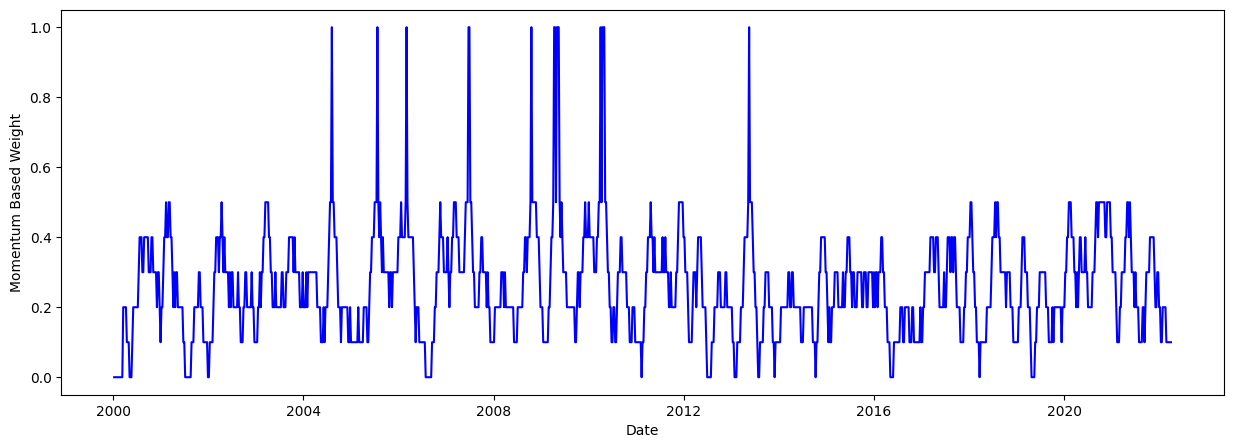

In [399]:
# Calculate Momentum Based Weight from returns of Virtual Portfolio
# Momentums are calucatled automatically without forward looking bias
mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,
                method = 'hurdle_smooth', hurdle=0.6)
# Plot Momentum Based Weight for Dynamic Optimization
plt.figure(figsize=(15,5))
plt.xlabel("Date", fontsize=10)
plt.ylabel("Momentum Based Weight", fontsize=10)
plt.plot(mom_weight, color='blue')

In [400]:
# Adjusted resampled weights
filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
momStrategy = STRATEGY()
momStrategy.straddle(
    upbeta=upbeta_,
    downbeta=downbeta_,
    long_stock_down_hurdle=1.1,
    short_stock_up_hurdle=0.95,#
    up_minus_down_hurdle=0.45,
    down_minus_up_hurdle=0.4,
    momentum_weight = filled_weight
)

Please Wait...
(5597,)
(5597, 1)


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12725.62it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


SnP500 market
CAGR: [0.05297627]
Sharpe: [0.59337333]
MDD: -0.5677538894035712
VOL: [0.08927983]

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.09549232]
Sharpe: [0.45989197]
MDD: -0.5138840978643942
VOL: [0.20764076]


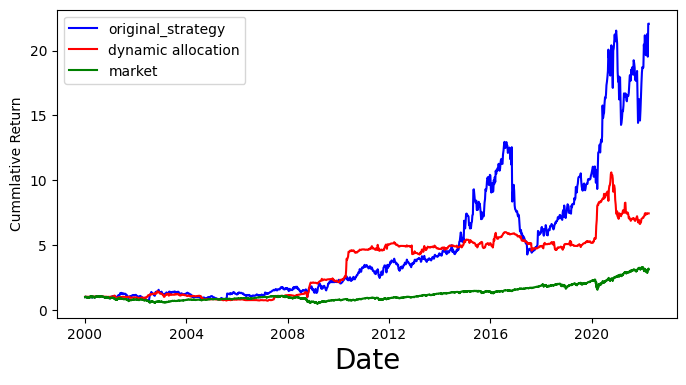

In [401]:
# Backtest the PF
mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )

# Plot Cummlative Returns of PFs
# Blue-Virtual_PF, Red-Momentum_Based_Weight_Adjusted PF, Green-S&P500

plt.figure(figsize=(8,4))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Cummlative Return", fontsize=10)

plt.plot((pf_return+1).cumprod(), color='blue')
plt.plot((mom_pf_return+1).cumprod(), color='red')
plt.plot((market_return+1).cumprod(), color='green')
plt.legend(['original_strategy', 'dynamic allocation', 'market'])

print("SnP500 market")
print("CAGR:", cagr(cum(market_return)).values)
print("Sharpe:", sharpe(market_return, days=52).values)
print("MDD:", max_dd(cum(market_return)))
print("VOL:", cagr(cum(market_return)).values / sharpe(market_return, days=52).values)
print()

print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

print()
print("Beta-Asymmetry with strategy-based momentum")
print("CAGR:", cagr(cum(mom_pf_return)).values)
print("Sharpe:", sharpe(mom_pf_return, days=52).values)
print("MDD:", max_dd(cum(mom_pf_return)))
print("VOL:", cagr(cum(mom_pf_return)).values / sharpe(mom_pf_return, days=52).values)

plt.show()

2000 ~ 2010
SnP500 market
CAGR: [-0.01448607]
Sharpe: [-0.14576318]
MDD: -0.5677538894035712
VOL: [0.09938083]

Beta-Asymmetry Strategy
CAGR: [0.12517022]
Sharpe: [0.30863622]
MDD: -0.4880511995417284
VOL: [0.40555908]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.16624269]
Sharpe: [0.69460543]
MDD: -0.5138840978643942
VOL: [0.23933399]


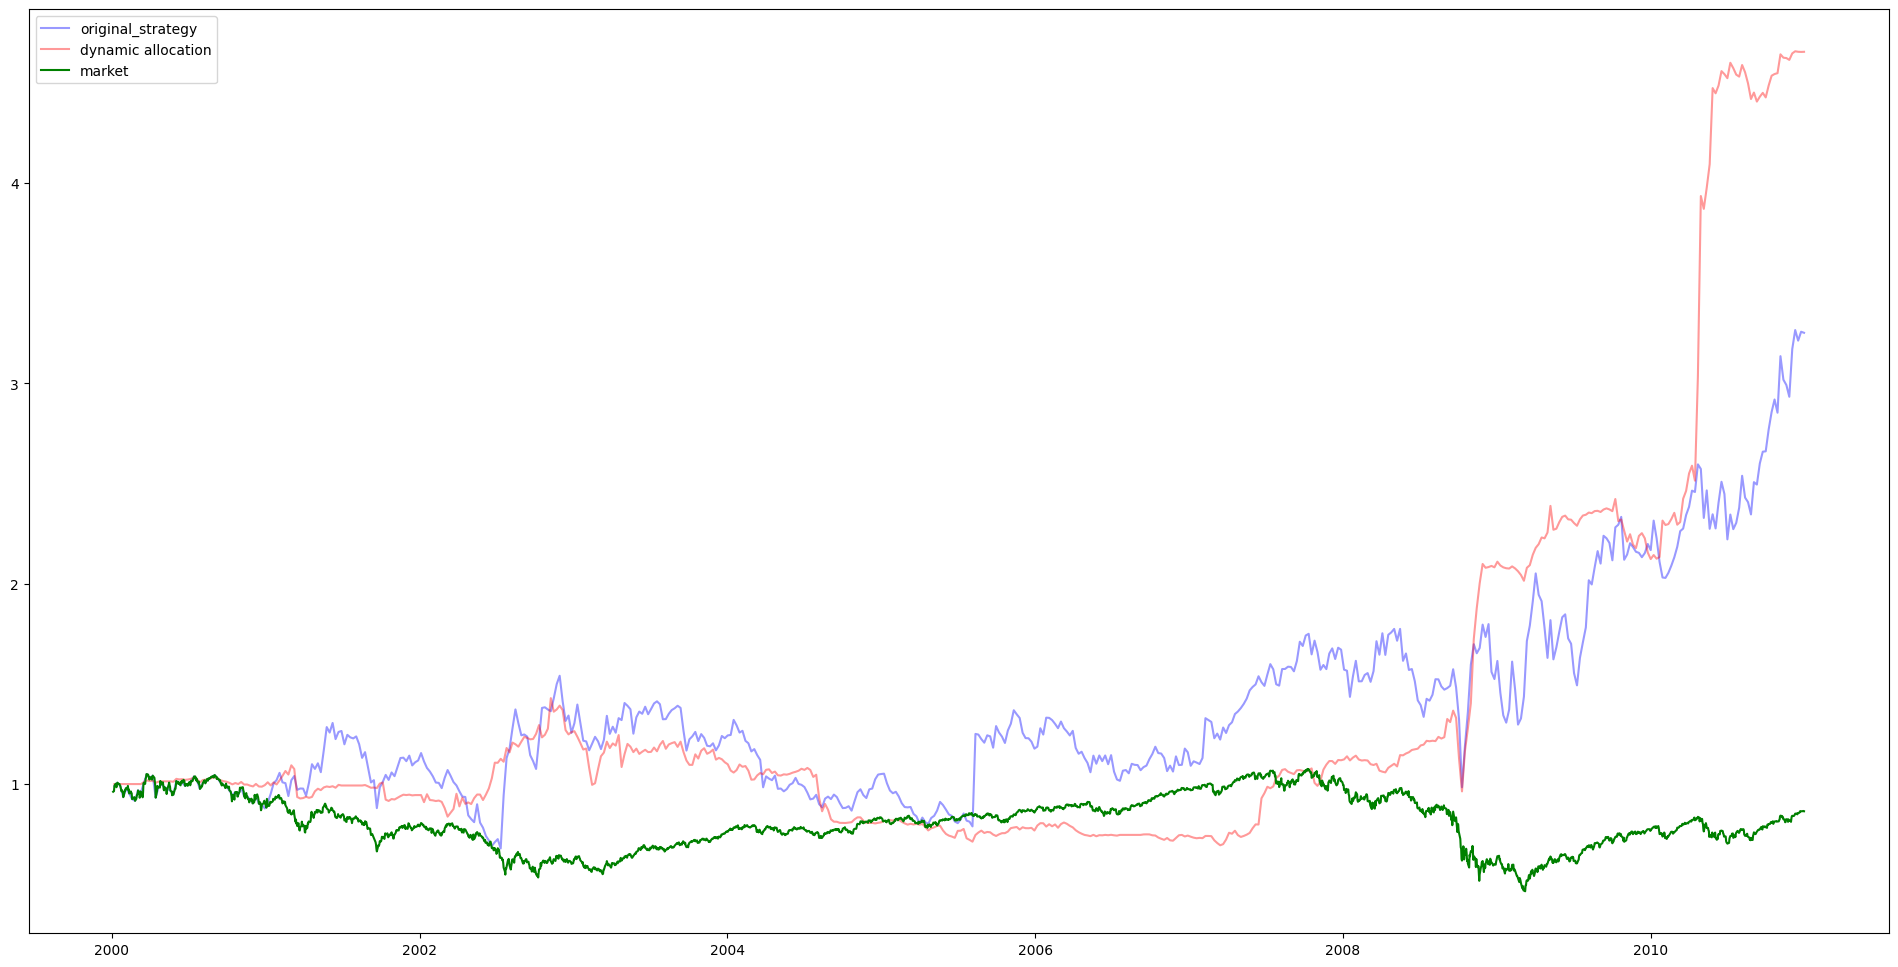

2010 ~ 2020
SnP500 market
CAGR: [0.1291249]
Sharpe: [1.62477187]
MDD: -0.3392495902426059
VOL: [0.07947264]

Beta-Asymmetry Strategy
CAGR: [0.25328342]
Sharpe: [0.7113016]
MDD: -0.6709391348503122
VOL: [0.35608443]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.13075815]
Sharpe: [0.65257831]
MDD: -0.30527967469524264
VOL: [0.20037158]


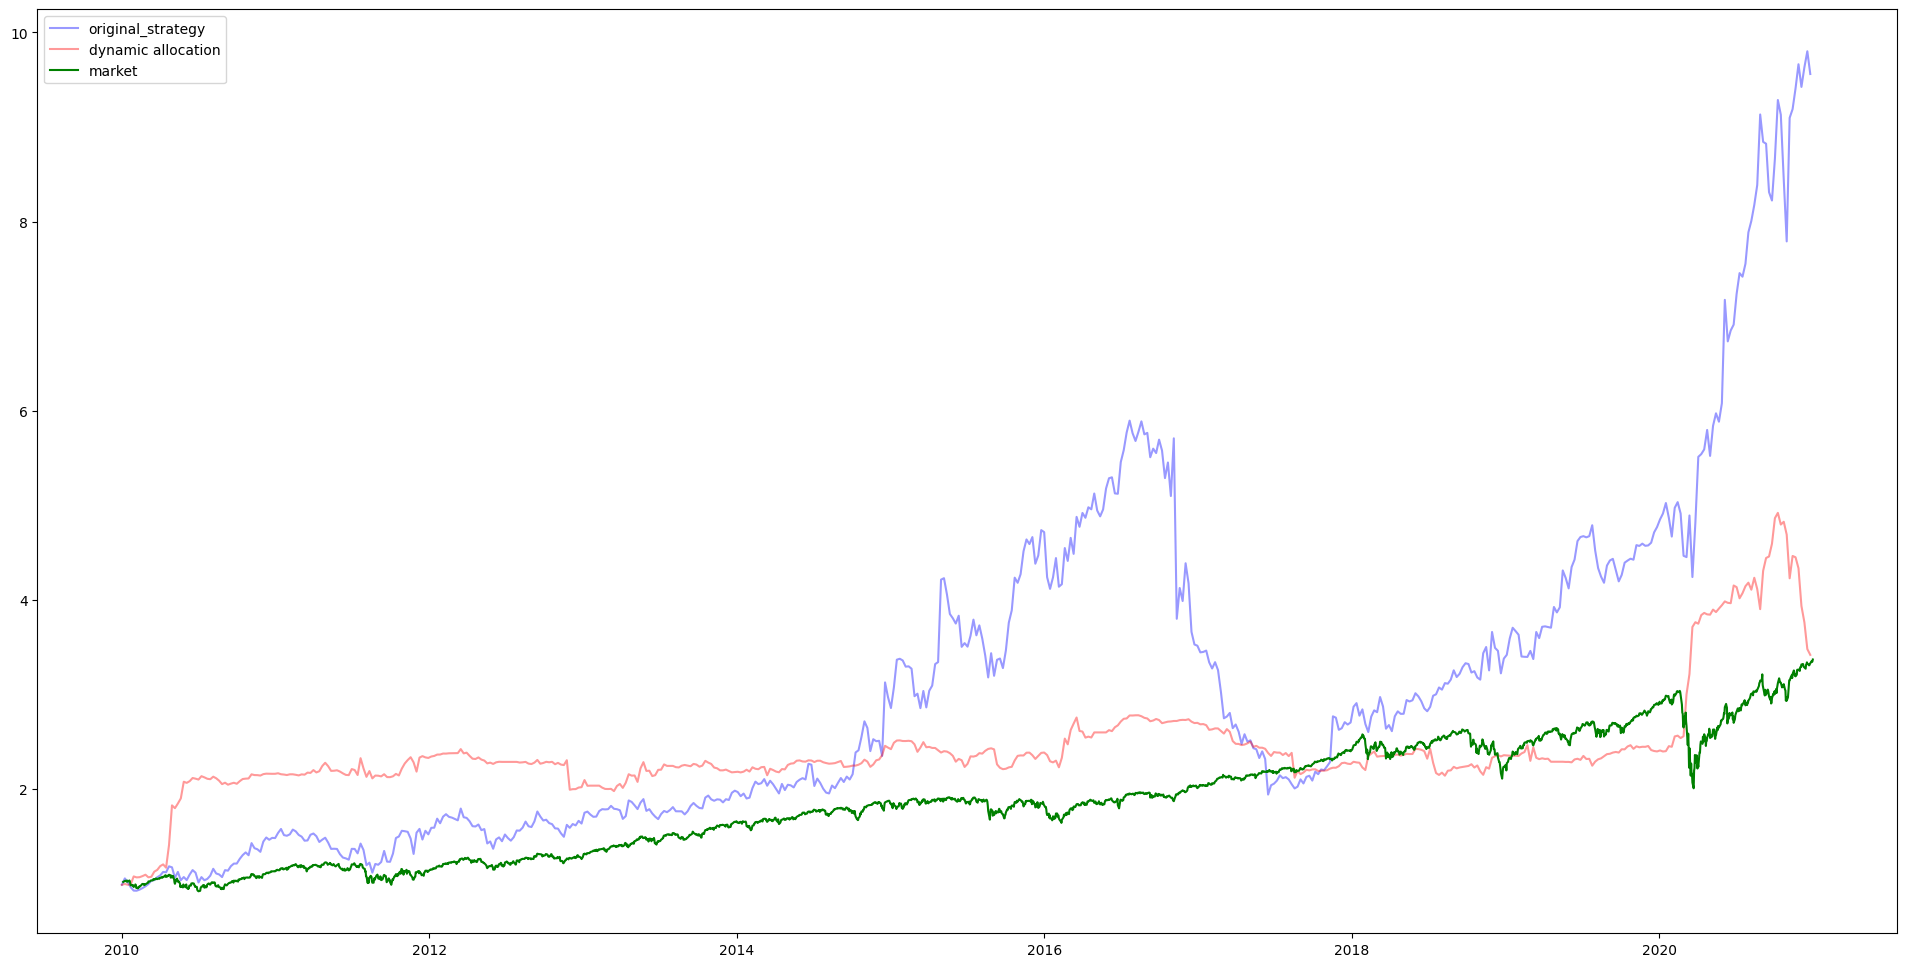

In [402]:
# Visuaized the Periodic Performance of Real PF
for start_year in [2000,2010]:
    end_year = str(start_year+10)
    start_year = str(start_year)
    print(start_year, "~", end_year)
    print("SnP500 market")
    print("CAGR:", cagr(cum(market_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(market_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(market_return[start_year:end_year])))
    print("VOL:", cagr(cum(market_return[start_year:end_year])).values / sharpe(market_return[start_year:end_year], days=52).values)
    print()

    
    print("Beta-Asymmetry Strategy")
    print("CAGR:", cagr(cum(pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(pf_return[start_year:end_year])).values / sharpe(pf_return[start_year:end_year], days=52).values)
    
    print()
    print("Beta-Asymmetry with strategy-based momentum")
    print("CAGR:", cagr(cum(mom_pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(mom_pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(mom_pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(mom_pf_return[start_year:end_year])).values / sharpe(mom_pf_return[start_year:end_year], days=52).values)
    plt.figure(figsize=(24,12))
    plt.plot((pf_return+1)[start_year:end_year].cumprod(), color='blue', alpha=0.4)
    plt.plot((mom_pf_return+1)[start_year:end_year].cumprod(), color='red', alpha=0.4)
    plt.plot((market_return+1)[start_year:end_year].cumprod(), color='green')
    plt.legend(['original_strategy', 'dynamic allocation', 'market'])
    plt.show()

In [307]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [109]:
# Preprocess KR Data
kr_stock = pd.read_csv(loc+"Data/krx_data.csv", index_col=0)
kr_market = pd.read_csv(loc+"Data/krx_market.csv", encoding='cp949')[["일자","종가"]]

# KRX Preprocessing
kr_stock.index = pd.to_datetime(kr_stock.index)

kr_market["일자"] = pd.to_datetime(kr_market["일자"], format="%Y/%m/%d")
kr_market.index = kr_market["일자"]
kr_market = kr_market.drop("일자", axis=1)
kr_market = kr_market.sort_index(ascending=True)

# Preprocess
for idx in kr_market.index:
    if idx not in kr_stock.index:
        kr_market = kr_market.drop(idx, axis=0)

for idx in kr_stock.index:
    if idx not in kr_market.index:
        kr_stock = kr_stock.drop(idx, axis=0)


Please Wait...


Winsorizing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5431/5431 [00:03<00:00, 1572.77it/s]

Please Wait...


  0%|                                                                                                         …

### Calculation Complete ###
Check the result with .beta & .tstat & .lack

Warning! Below stocks don't have enough observations to calculate Beta under given window size(252)
['315640' '247660' '377990' '361670' '570056' '412770' '294570' '530089'
 '347700' '376250' '352480' '530076' '387280' '375770' '530077' '367360'
 '530088' '411720' '570057' '395280' '357880' '385520' '372800' '385720'
 '367000' '570055' '411050' '376290' '409810' '530075' '381180' '530074'
 '412570' '377400' '352910' '570054' '570068' '400570' '195940' '411860'
 '510015' '400560' '383220' '412560' '580016' '404470' '580017' '396770'
 '348030' '510014' '391590' '137310' '329180' '383800' '510016' '570053'
 '363260' '395290' '366330' '382840' '580029' '375760' '530073' '530072'
 '580028' '276730' '570052' '510017' '381970' '404260' '400760' '500061'
 '950220' '411420' '402460' '610023' '314930' '411540' '520038' '400840'
 '361570' '520039' '139990' '610036' '610022' '303530' '394670' '500060'
 '395750' '163730' '50

  0%|                                                                                                         …

### Calculation Complete ###
Check the result with .beta & .tstat & .lack

Warning! Below stocks don't have enough observations to calculate Beta under given window size(252)
['315640' '247660' '377990' '361670' '570056' '412770' '294570' '530089'
 '347700' '376250' '352480' '530076' '387280' '375770' '530077' '367360'
 '530088' '411720' '570057' '395280' '357880' '385520' '372800' '385720'
 '367000' '570055' '411050' '376290' '409810' '530075' '381180' '530074'
 '412570' '377400' '352910' '570054' '570068' '400570' '195940' '411860'
 '510015' '400560' '383220' '412560' '580016' '404470' '580017' '396770'
 '348030' '510014' '391590' '137310' '329180' '383800' '510016' '570053'
 '363260' '395290' '366330' '382840' '580029' '375760' '530073' '530072'
 '580028' '276730' '570052' '510017' '381970' '404260' '400760' '500061'
 '950220' '411420' '402460' '610023' '314930' '411540' '520038' '400840'
 '361570' '520039' '139990' '610036' '610022' '303530' '394670' '500060'
 '395750' '163730' '50

Calculating short_weight...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5431/5431 [00:00<00:00, 15016.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1135/1135 [00:00<00:00, 190627.28it/s]


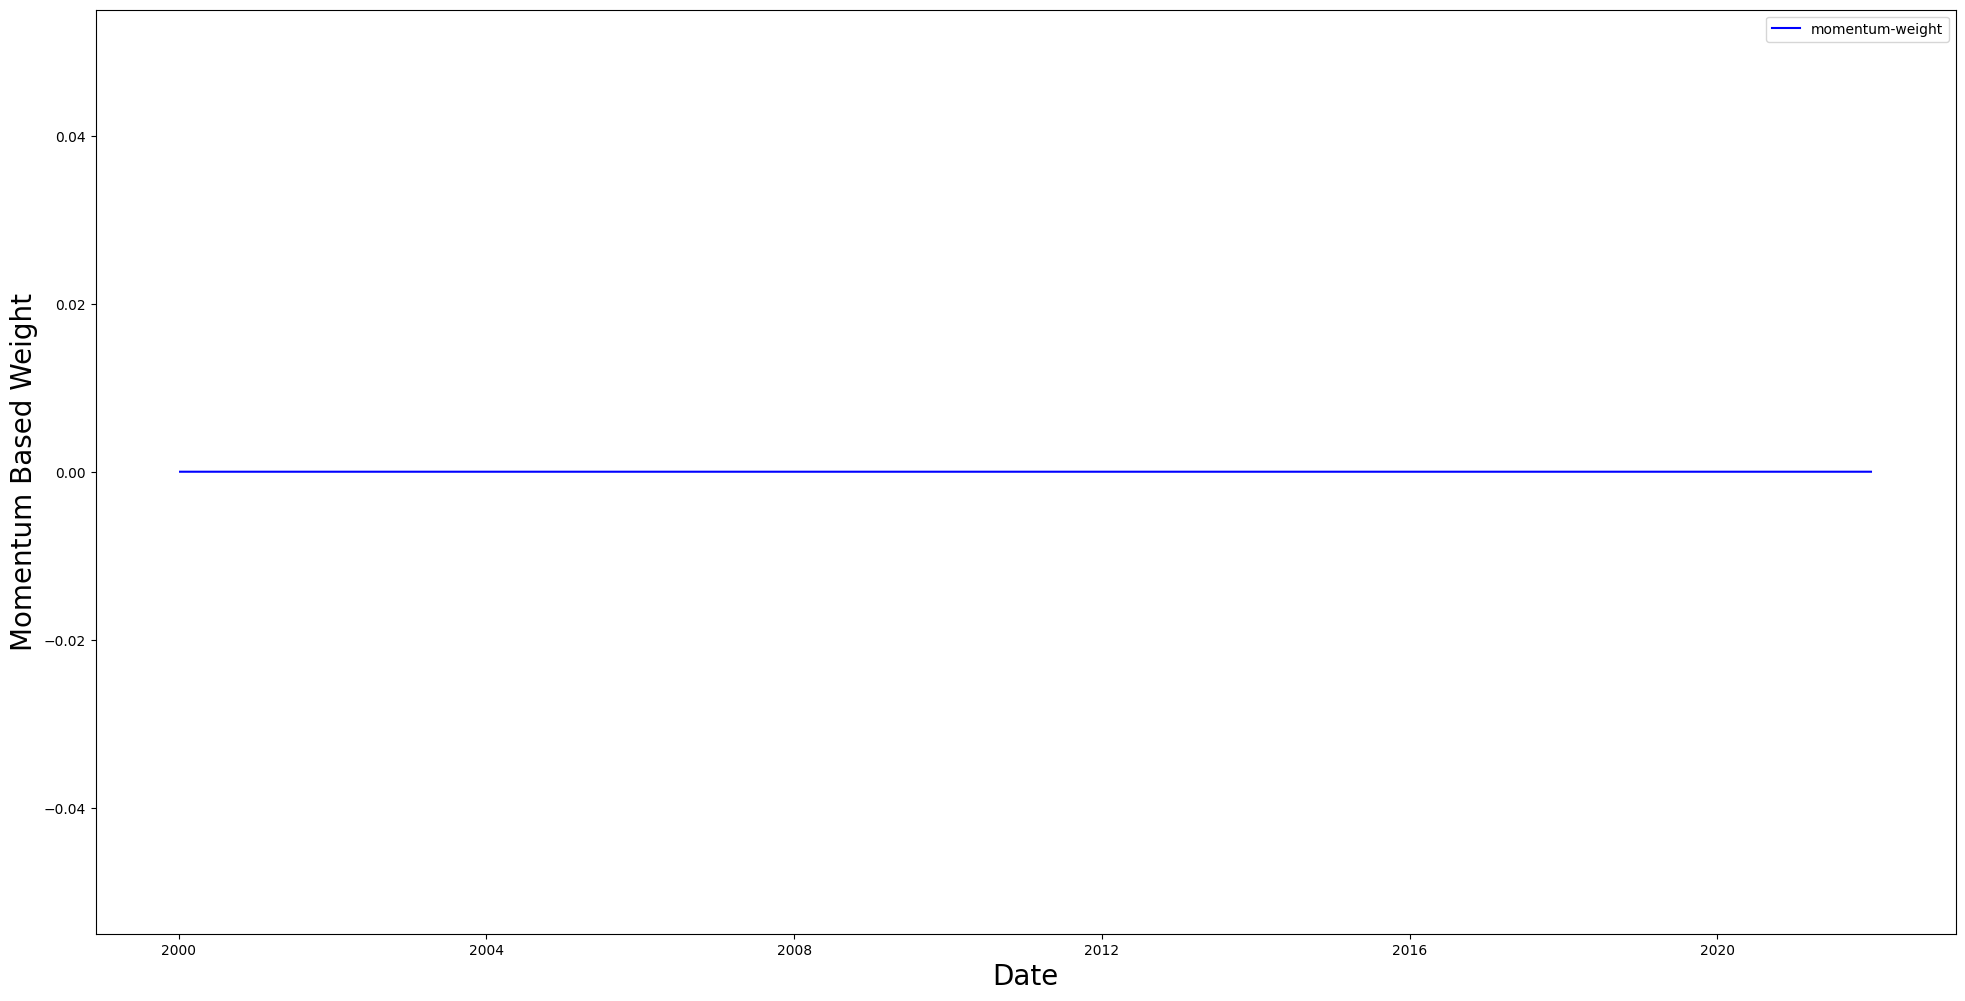

Please Wait...
(5431,)
(5431, 1)


Calculating short_weight...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5431/5431 [00:00<00:00, 15769.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


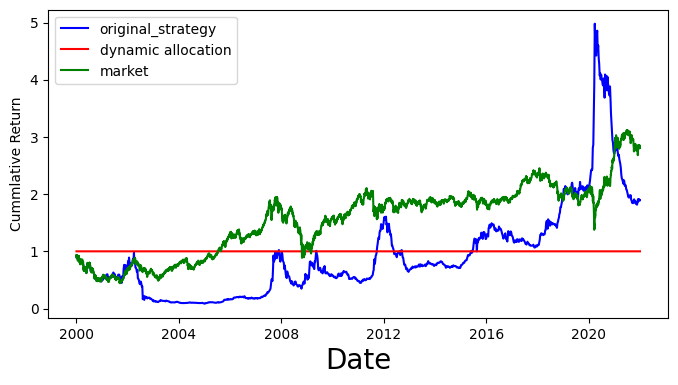

Beta-Asymmetry Strategy
CAGR: [0.03086805]
Sharpe: [0.07316899]
MDD: -0.9135555735533096
VOL: [0.42187347]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.]
Sharpe: [nan]
MDD: 0.0
VOL: [nan]
1990 ~ 2000


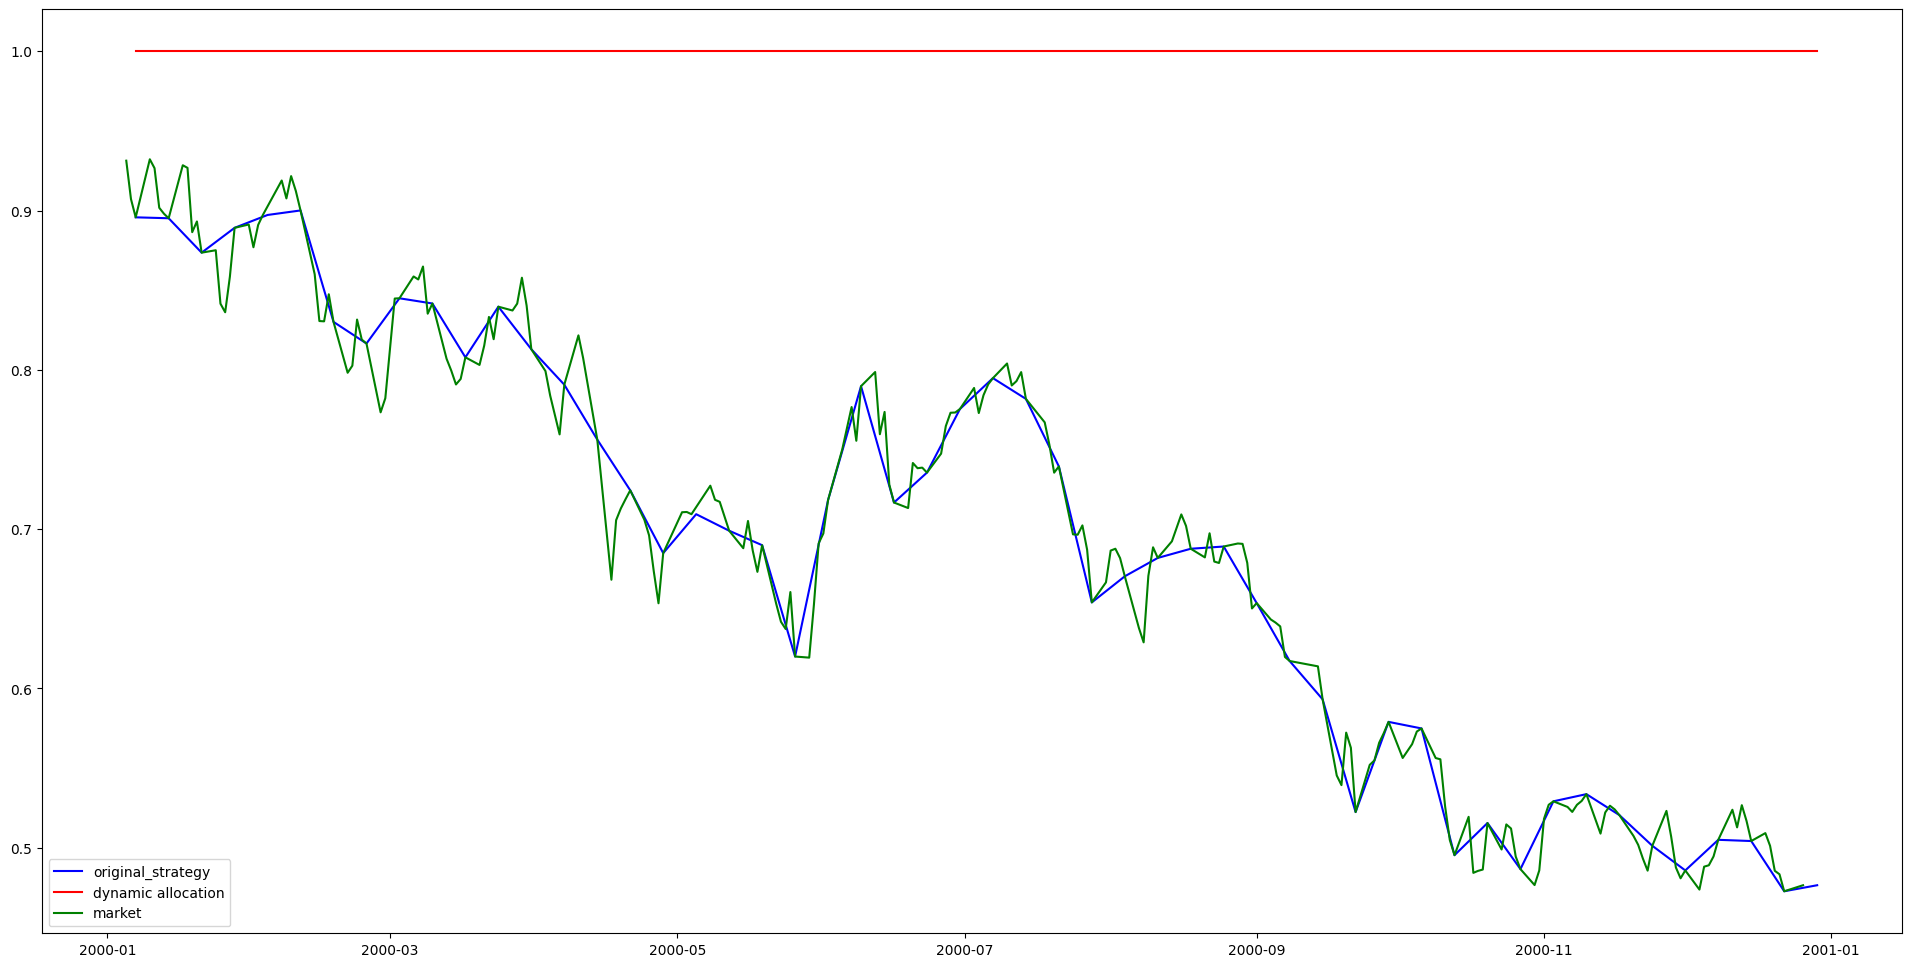

2000 ~ 2010


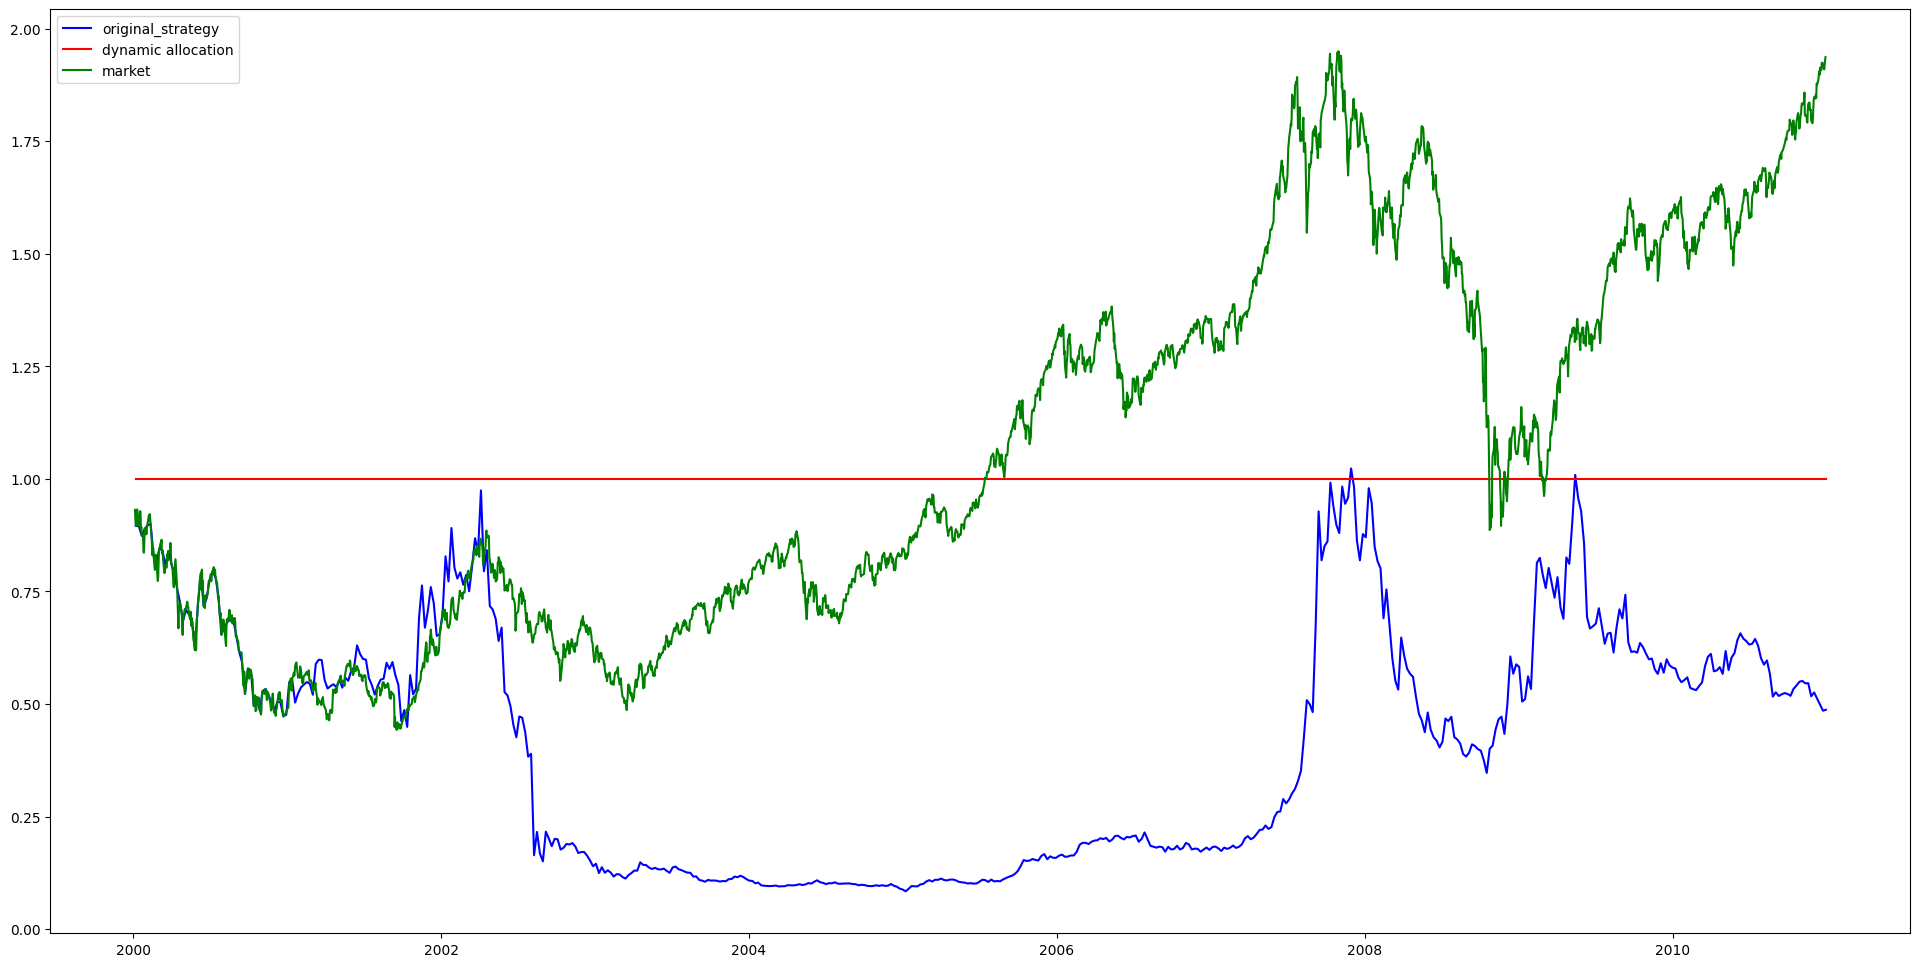

2010 ~ 2020


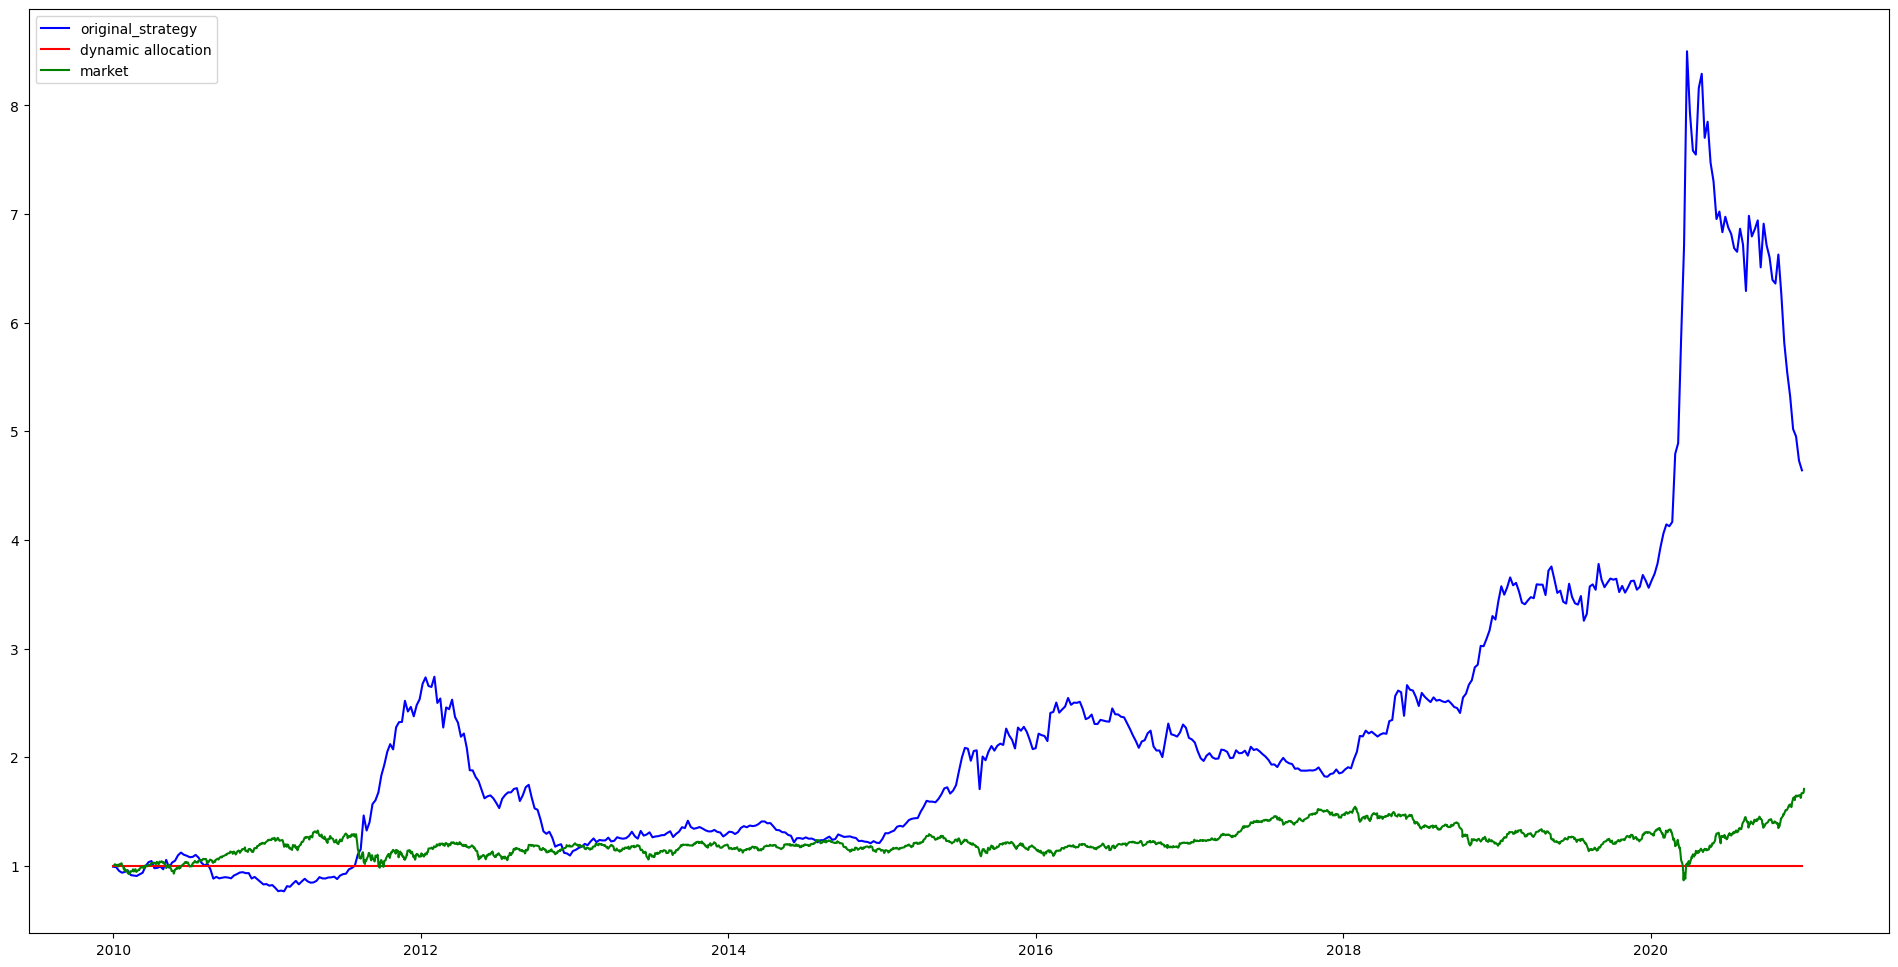

In [110]:
backtest(kr_stock, kr_market, screen = pd.DataFrame([[1]*kr_stock.shape[1]]*kr_stock.shape[0], columns=kr_stock.columns, index=kr_stock.index))